In [1]:
import torch

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

/home/mk/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
from dataset import DwgDataset
dwg_dataset = DwgDataset('test_dataset_cluster_labeled.pickle', batch_size = 2)
dim_features = dwg_dataset.entities.dim_features
ent_features = dwg_dataset.entities.ent_features

In [3]:
from model import DimTransformer
model = DimTransformer(ent_features=ent_features, dim_features=dim_features, hidden_size=1024, enforced_device=device)
model.to(device)


# https://pytorch.org/tutorials/beginner/saving_loading_models.html
model.load_state_dict(torch.load('DimTransformerTrained.model', map_location=device))

model.eval()

DimTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=4, out_features=4, bias=True)
          )
          (linear1): Linear(in_features=4, out_features=16, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=16, out_features=4, bias=True)
          (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_

In [4]:
import drawSvg as draw
from plot_graphics import draw_sample

tensor([0.5529, 0.1332, 0.8852, 0.1158], grad_fn=<SelectBackward>)
entities: 3051


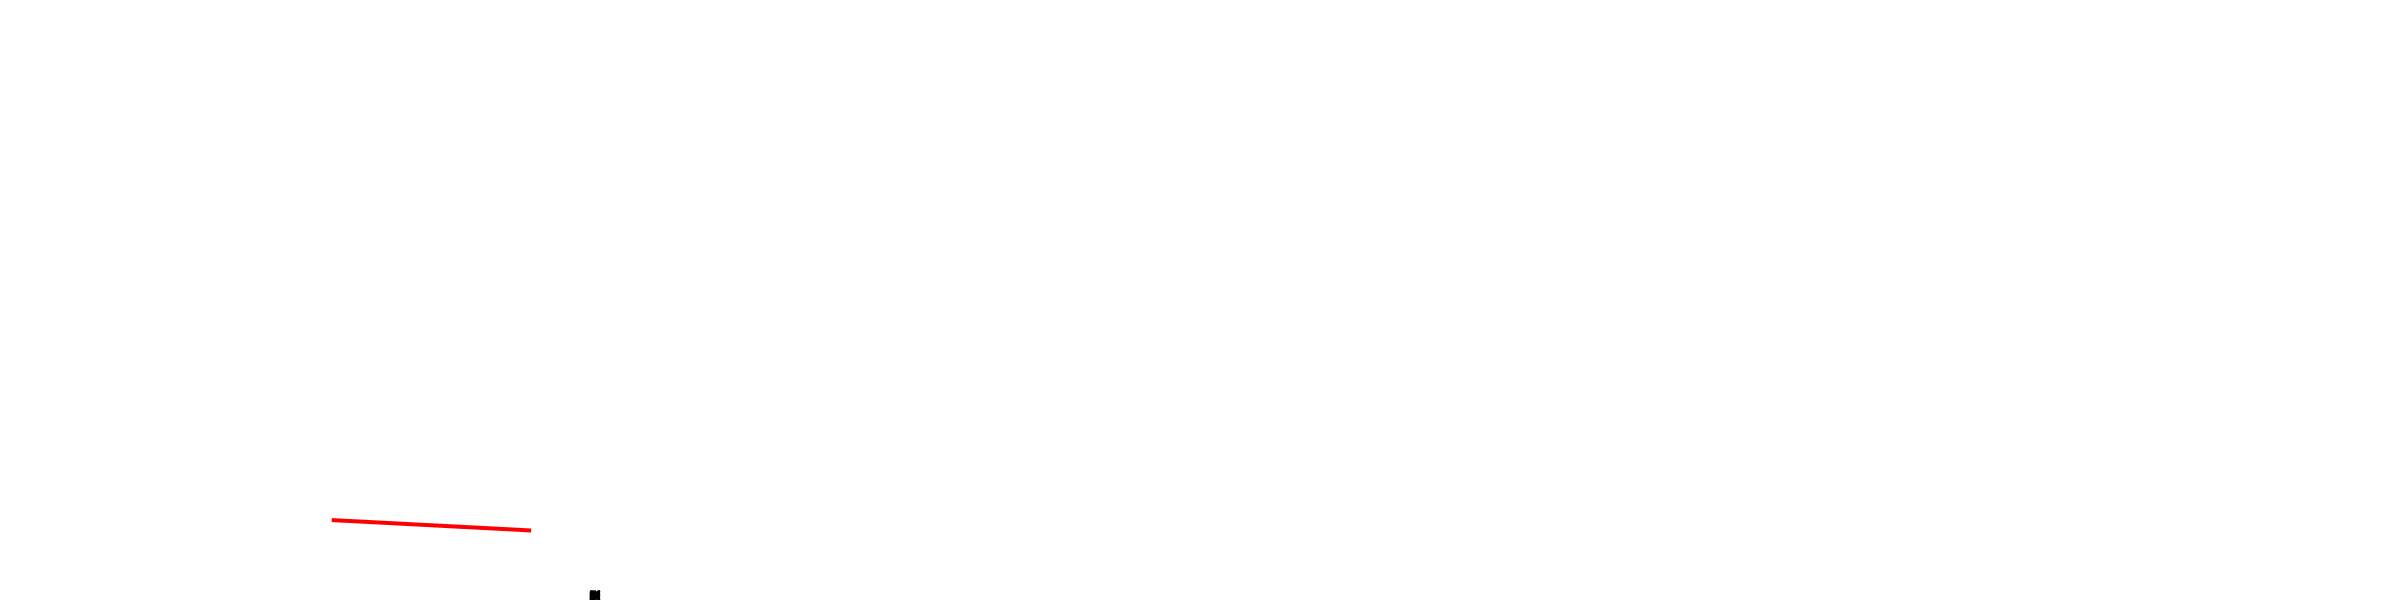

tensor([0.7027, 0.7478, 0.5453, 0.7652], grad_fn=<SelectBackward>)
entities: 89


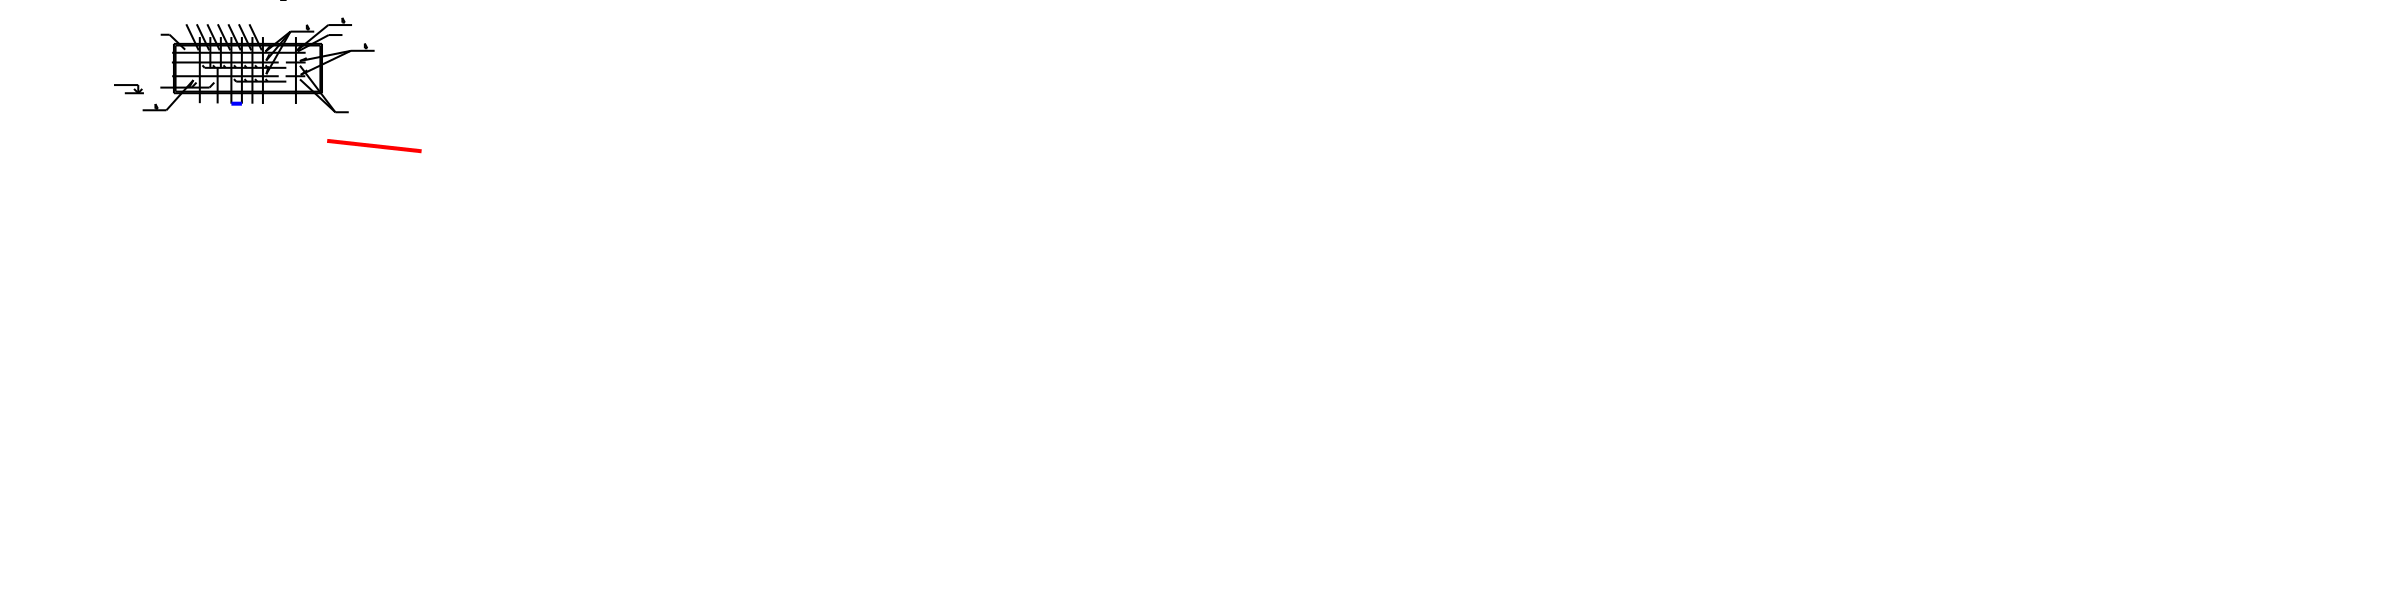

tensor([0.6912, 0.6369, 0.6418, 0.6448], grad_fn=<SelectBackward>)
entities: 33


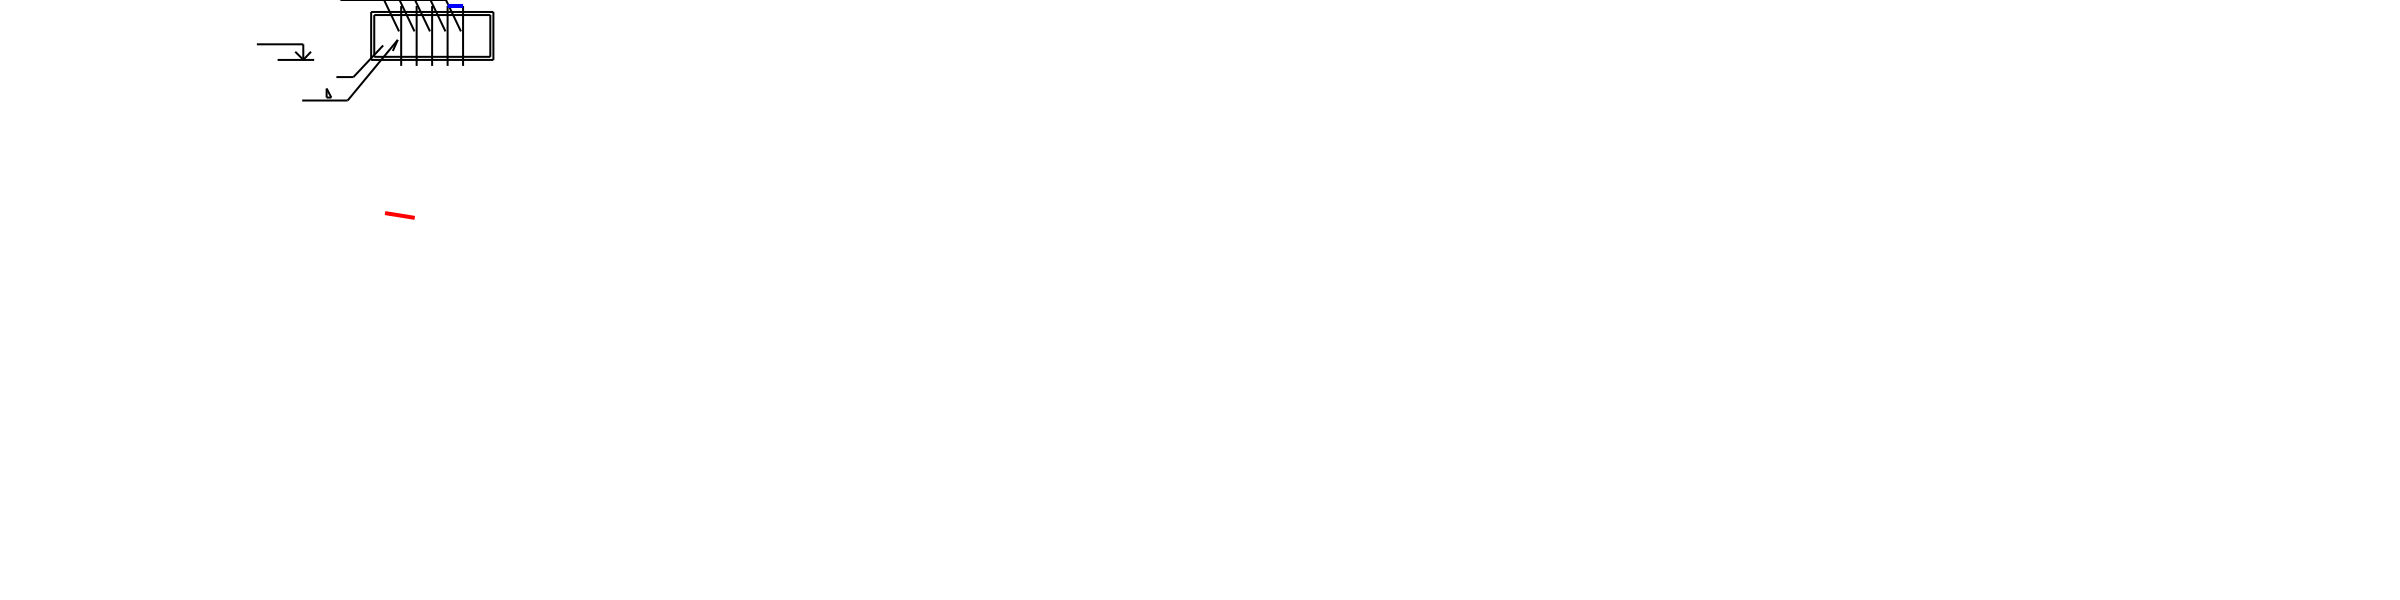

tensor([0.5528, 0.1329, 0.8853, 0.1155], grad_fn=<SelectBackward>)
entities: 3051


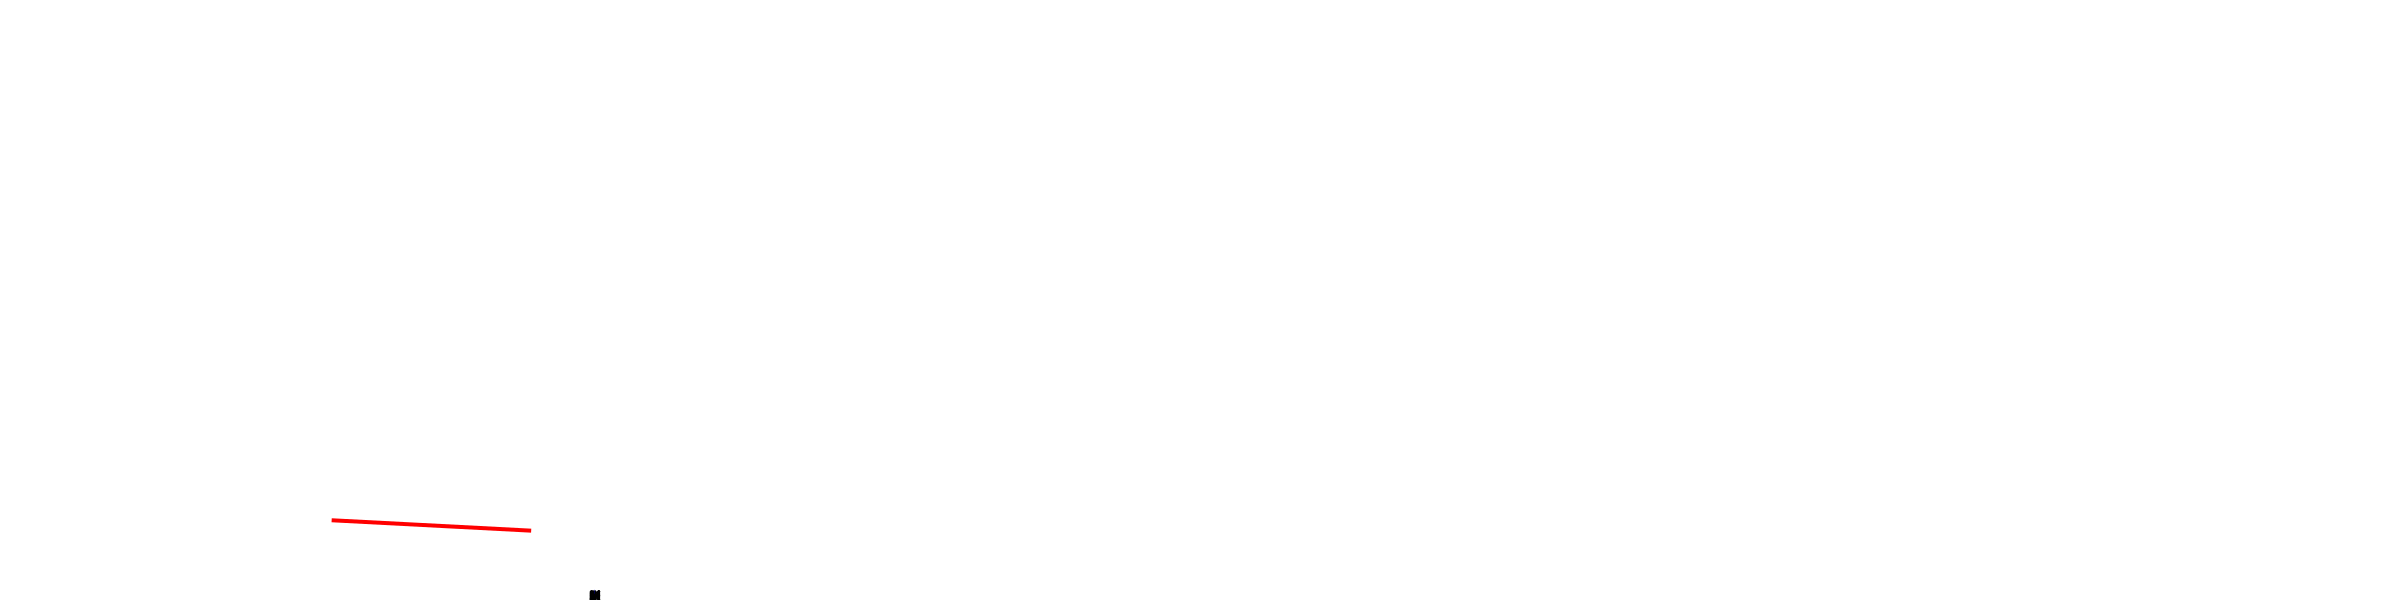

tensor([0.6791, 0.5634, 0.6977, 0.5609], grad_fn=<SelectBackward>)
entities: 167


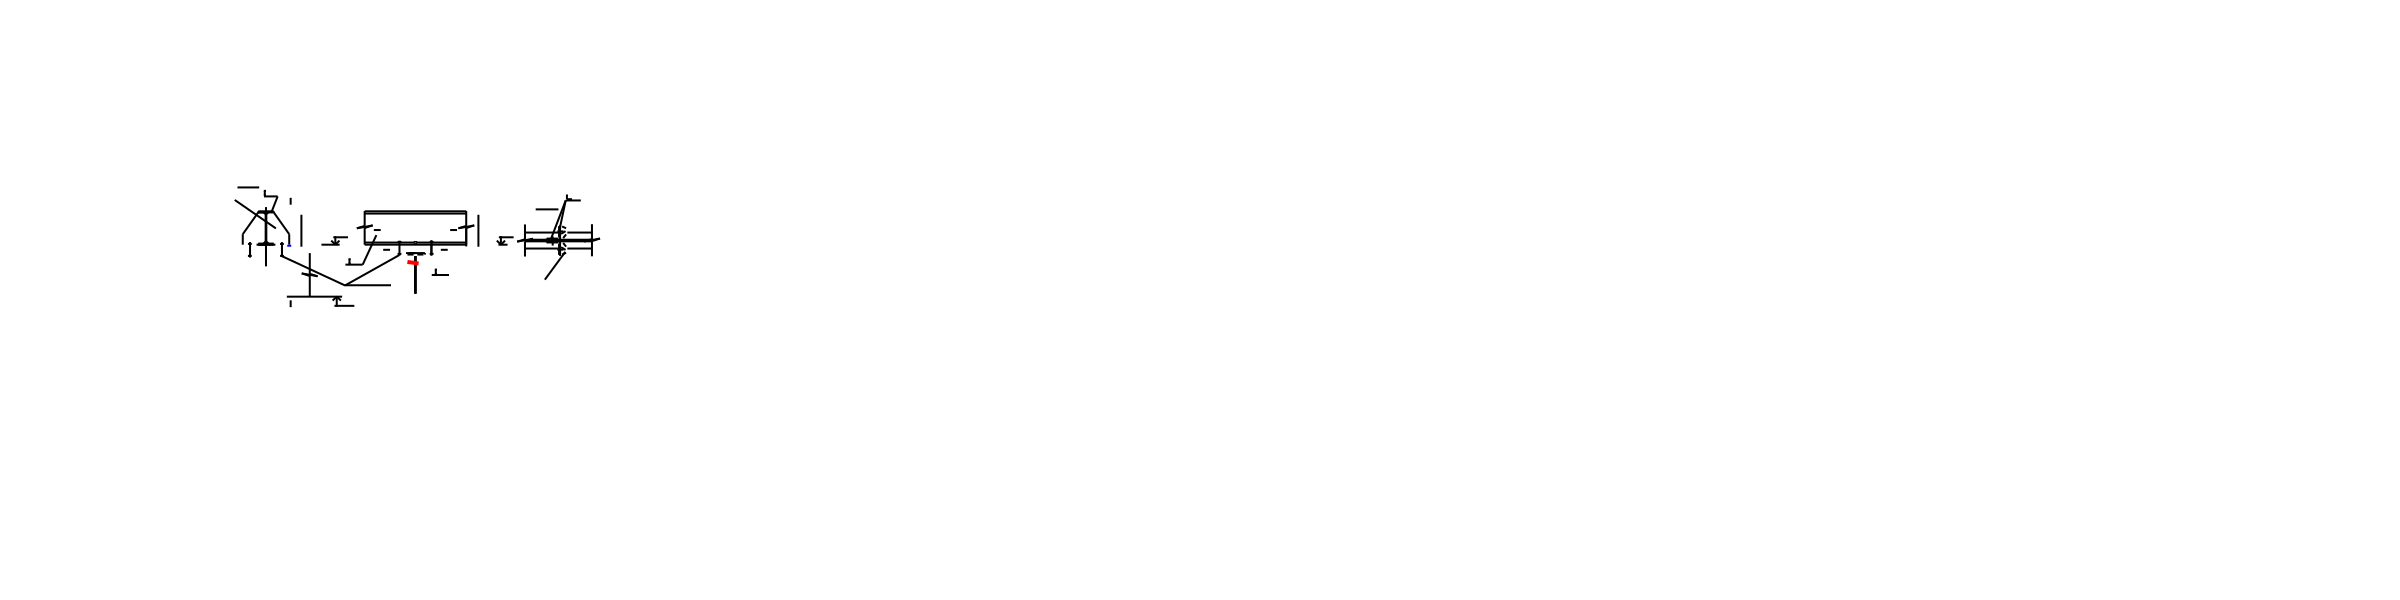

tensor([0.6156, 0.3096, 0.8358, 0.2904], grad_fn=<SelectBackward>)
entities: 1027


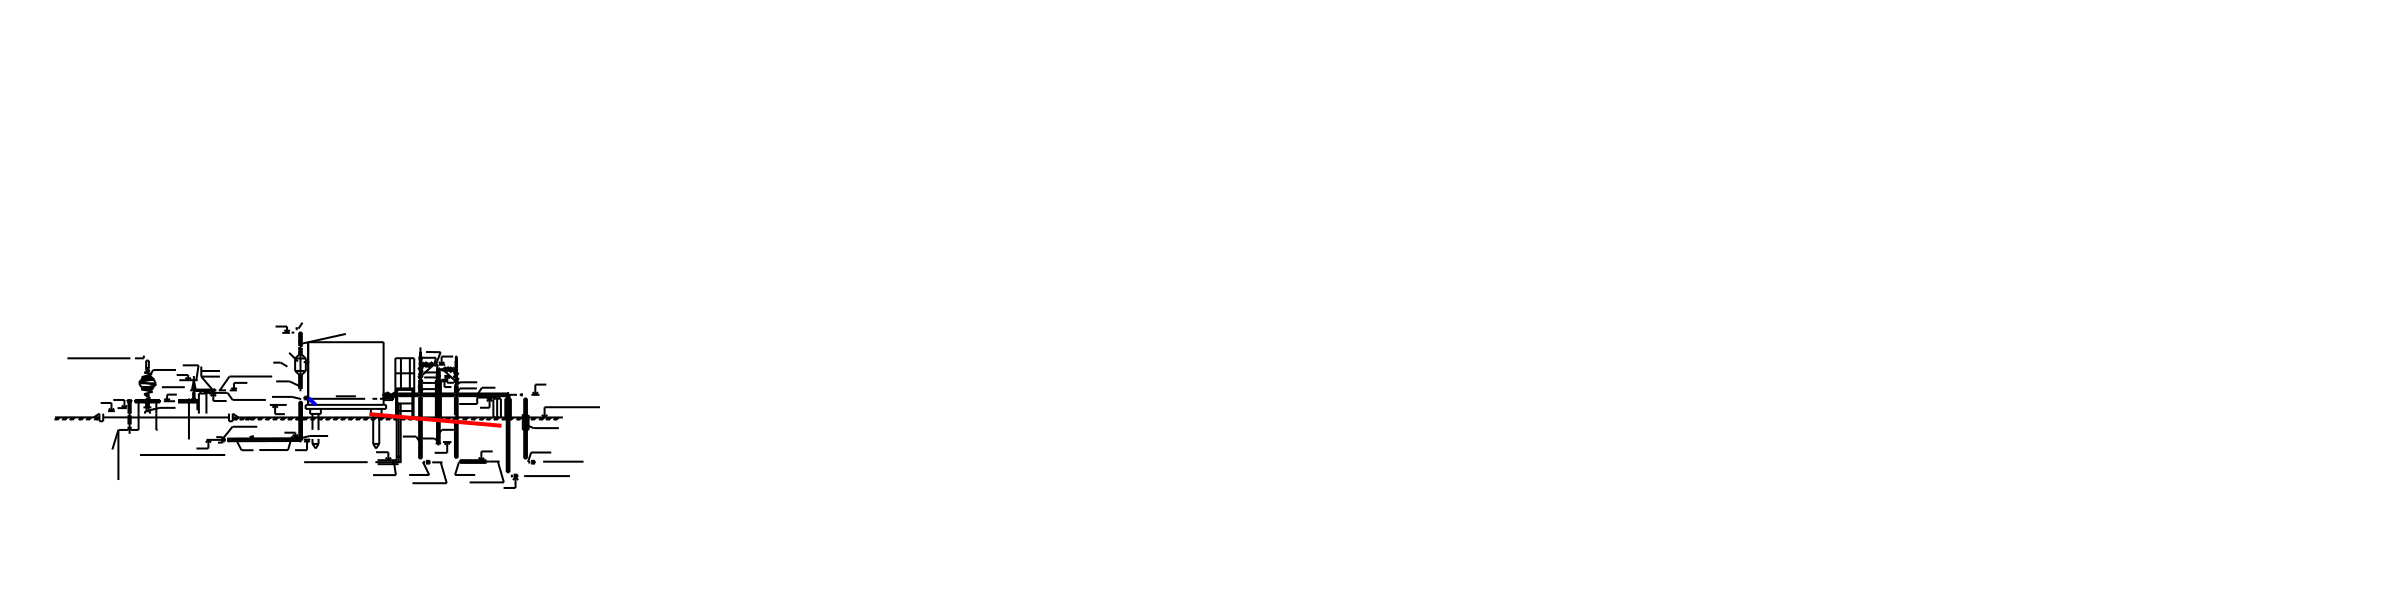

tensor([0.6589, 0.4659, 0.7590, 0.4586], grad_fn=<SelectBackward>)
entities: 80


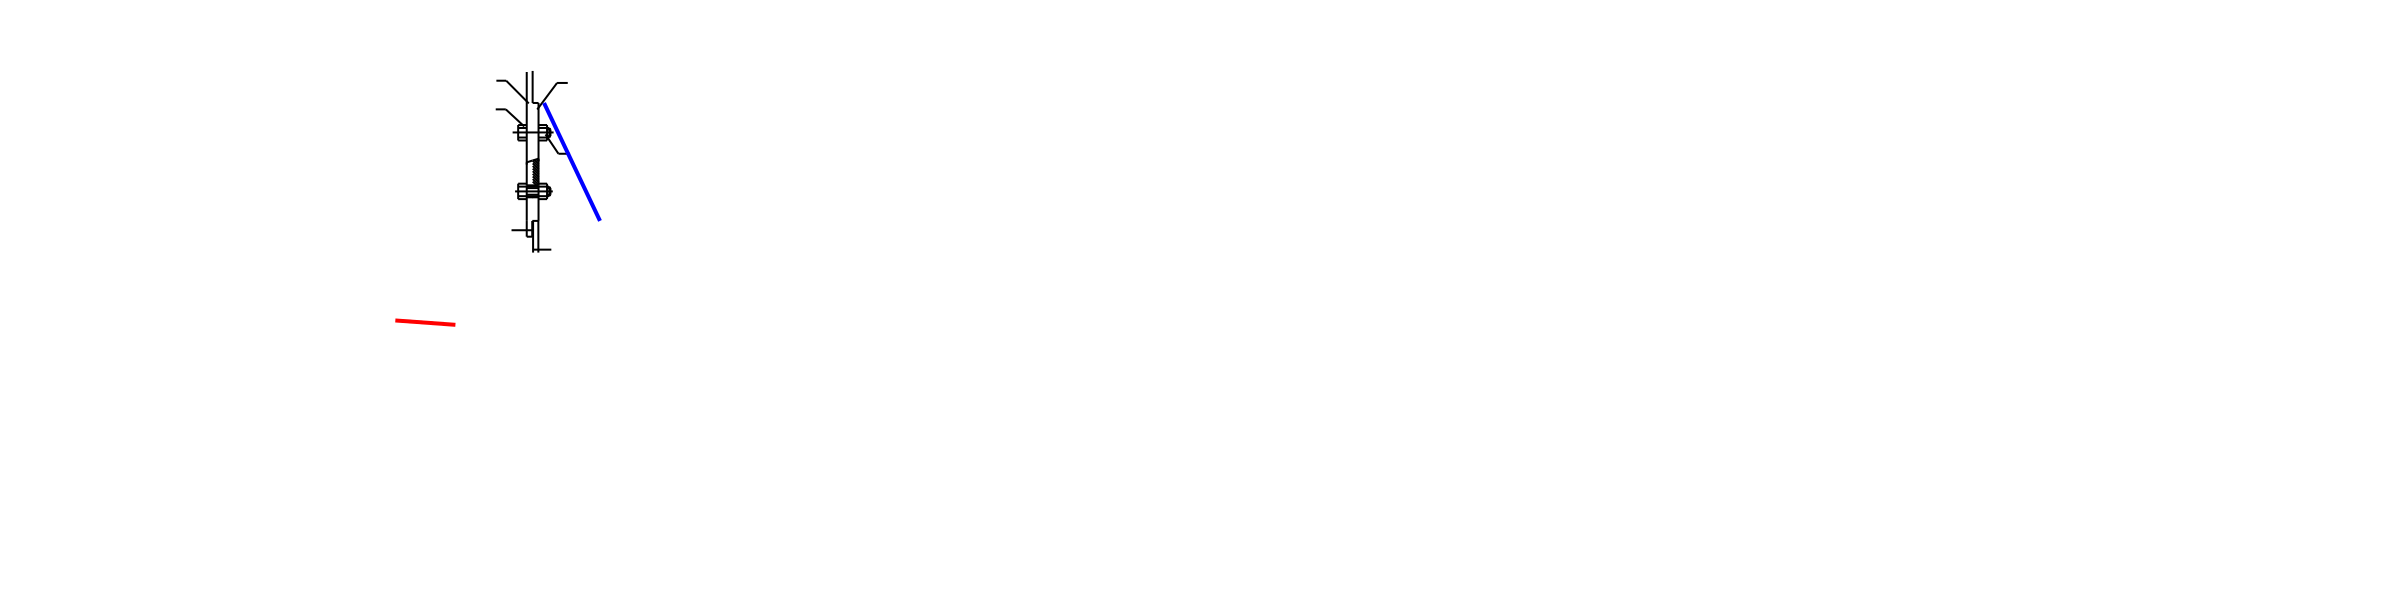

tensor([0.7040, 0.8744, 0.4193, 0.8833], grad_fn=<SelectBackward>)
entities: 26


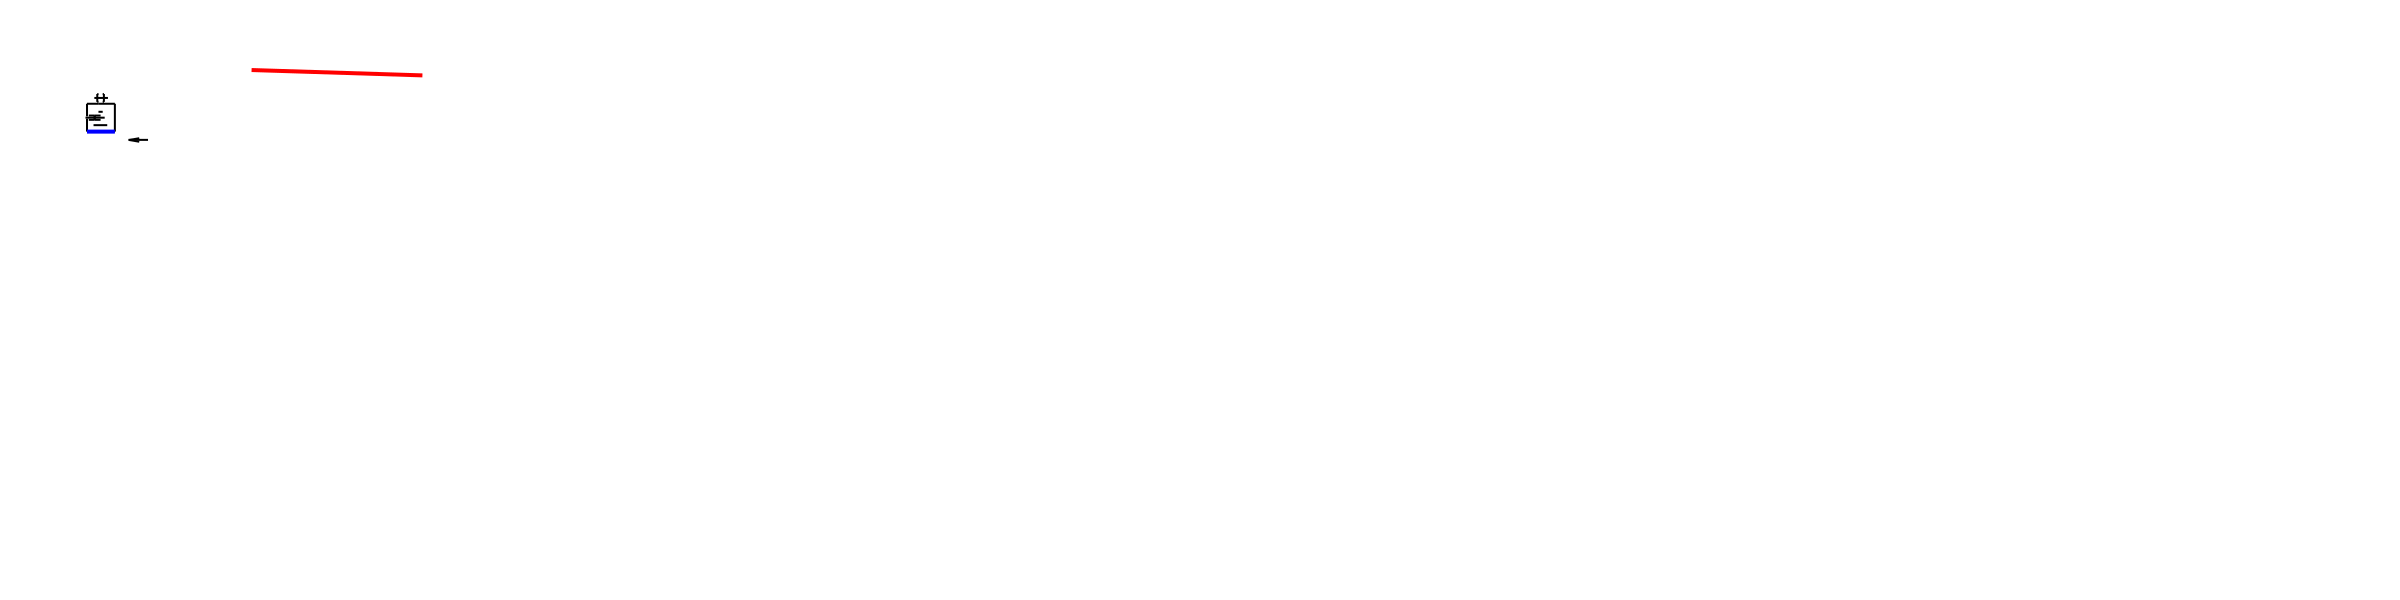

tensor([0.7028, 0.7490, 0.5432, 0.7686], grad_fn=<SelectBackward>)
entities: 89


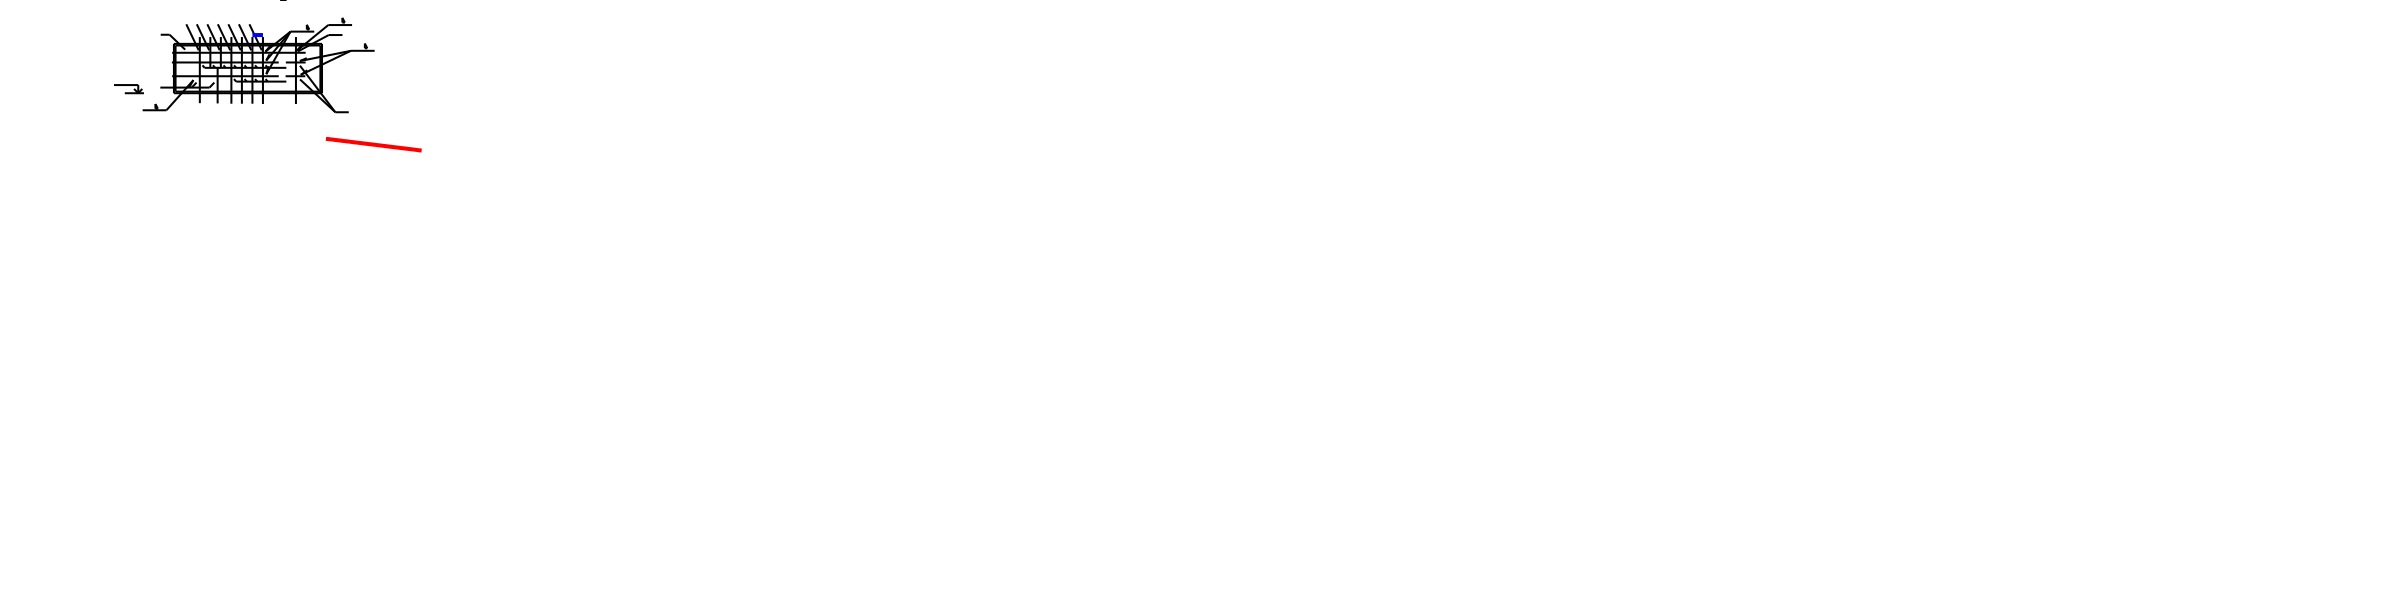

tensor([0.7041, 0.8700, 0.4212, 0.8849], grad_fn=<SelectBackward>)
entities: 151


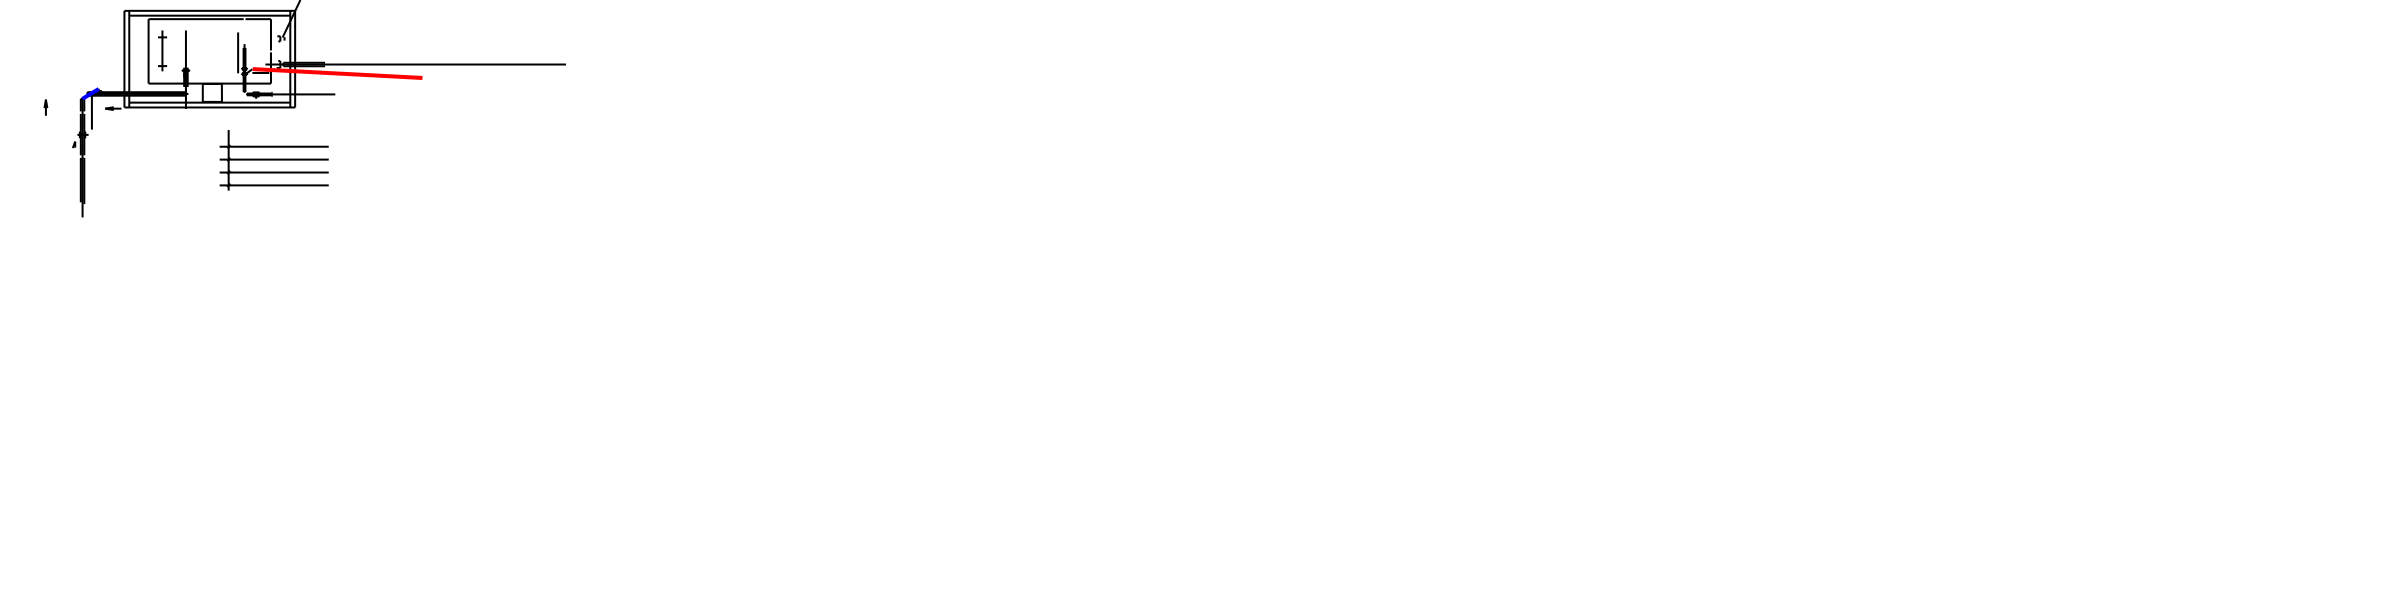

tensor([0.6964, 0.6769, 0.6087, 0.6891], grad_fn=<SelectBackward>)
entities: 1014


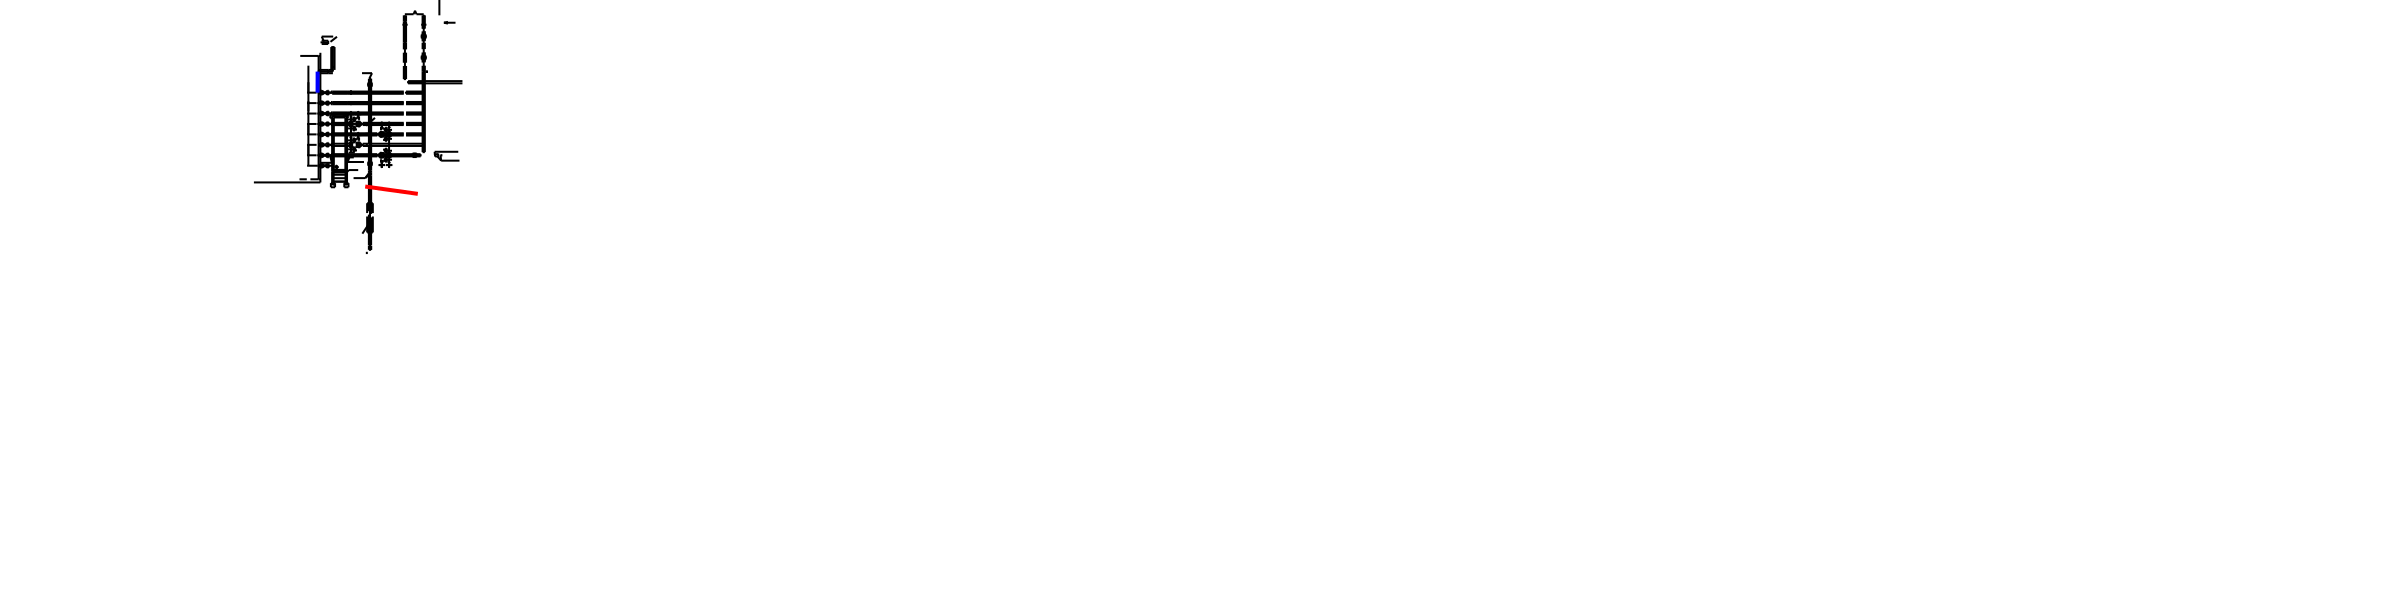

tensor([0.6234, 0.3322, 0.8255, 0.3200], grad_fn=<SelectBackward>)
entities: 1027


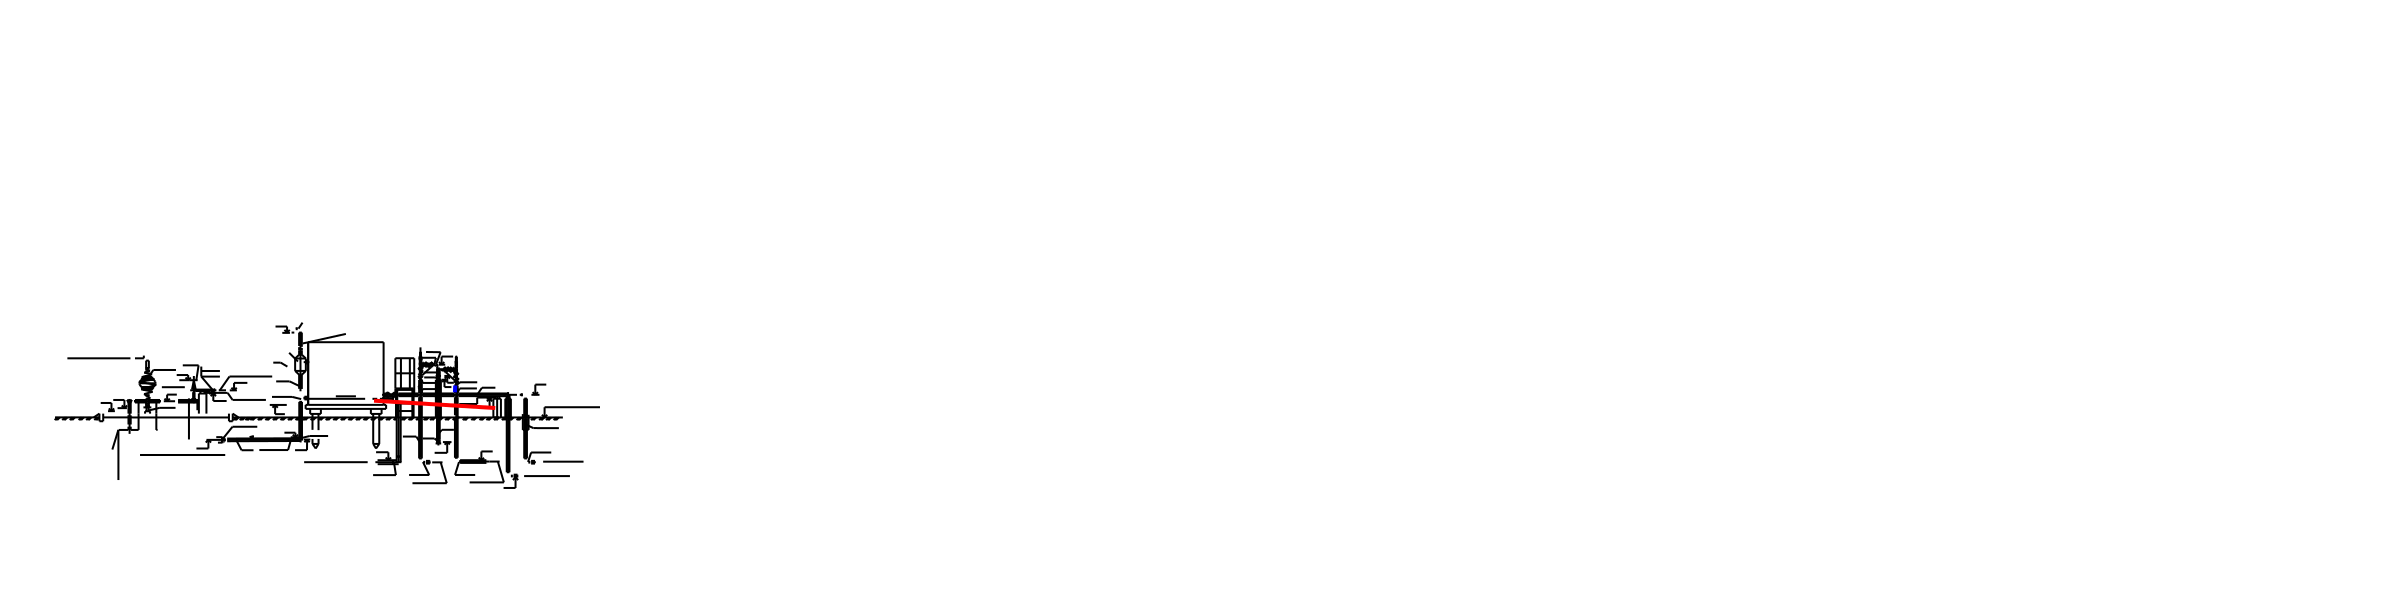

tensor([0.6159, 0.3099, 0.8355, 0.2921], grad_fn=<SelectBackward>)
entities: 468


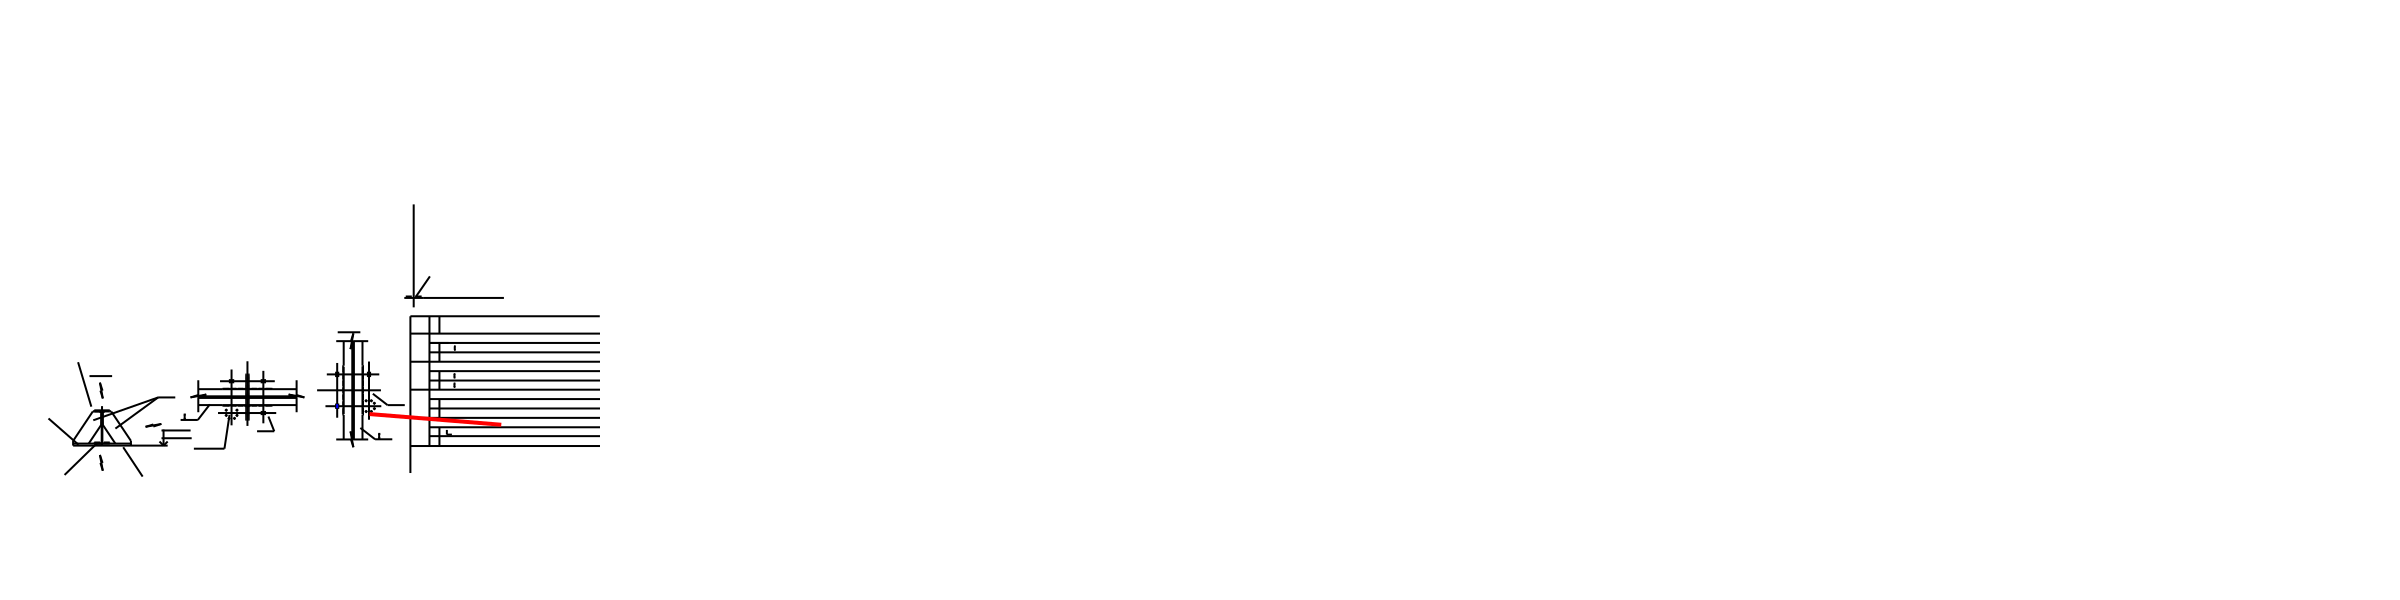

tensor([0.5670, 0.1668, 0.8784, 0.1533], grad_fn=<SelectBackward>)
entities: 71


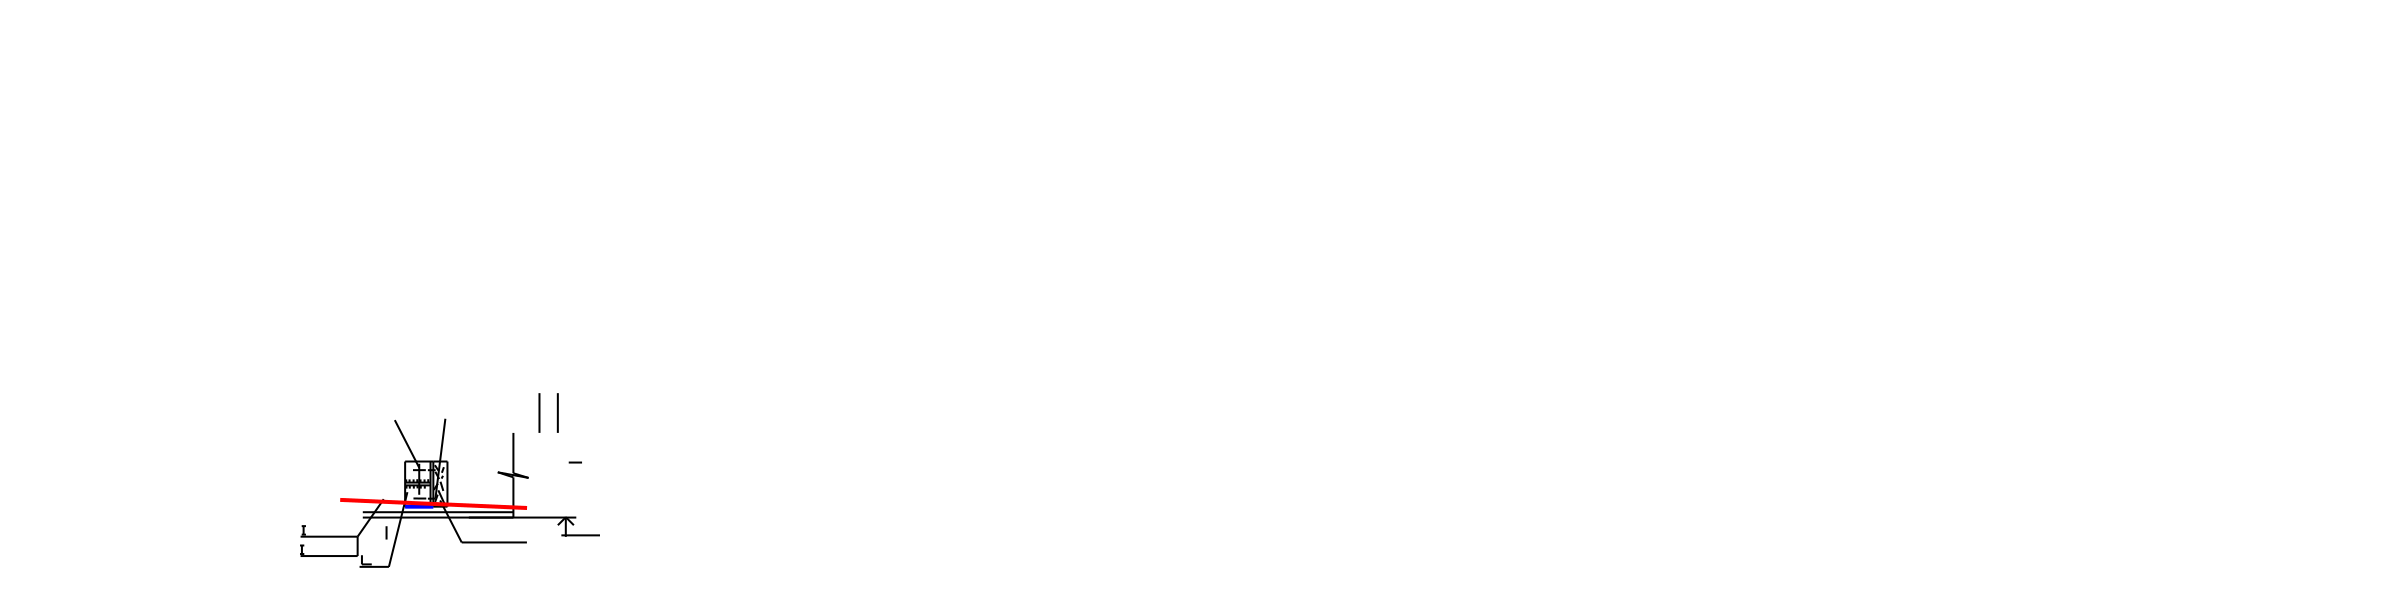

tensor([0.6407, 0.3958, 0.7976, 0.3800], grad_fn=<SelectBackward>)
entities: 468


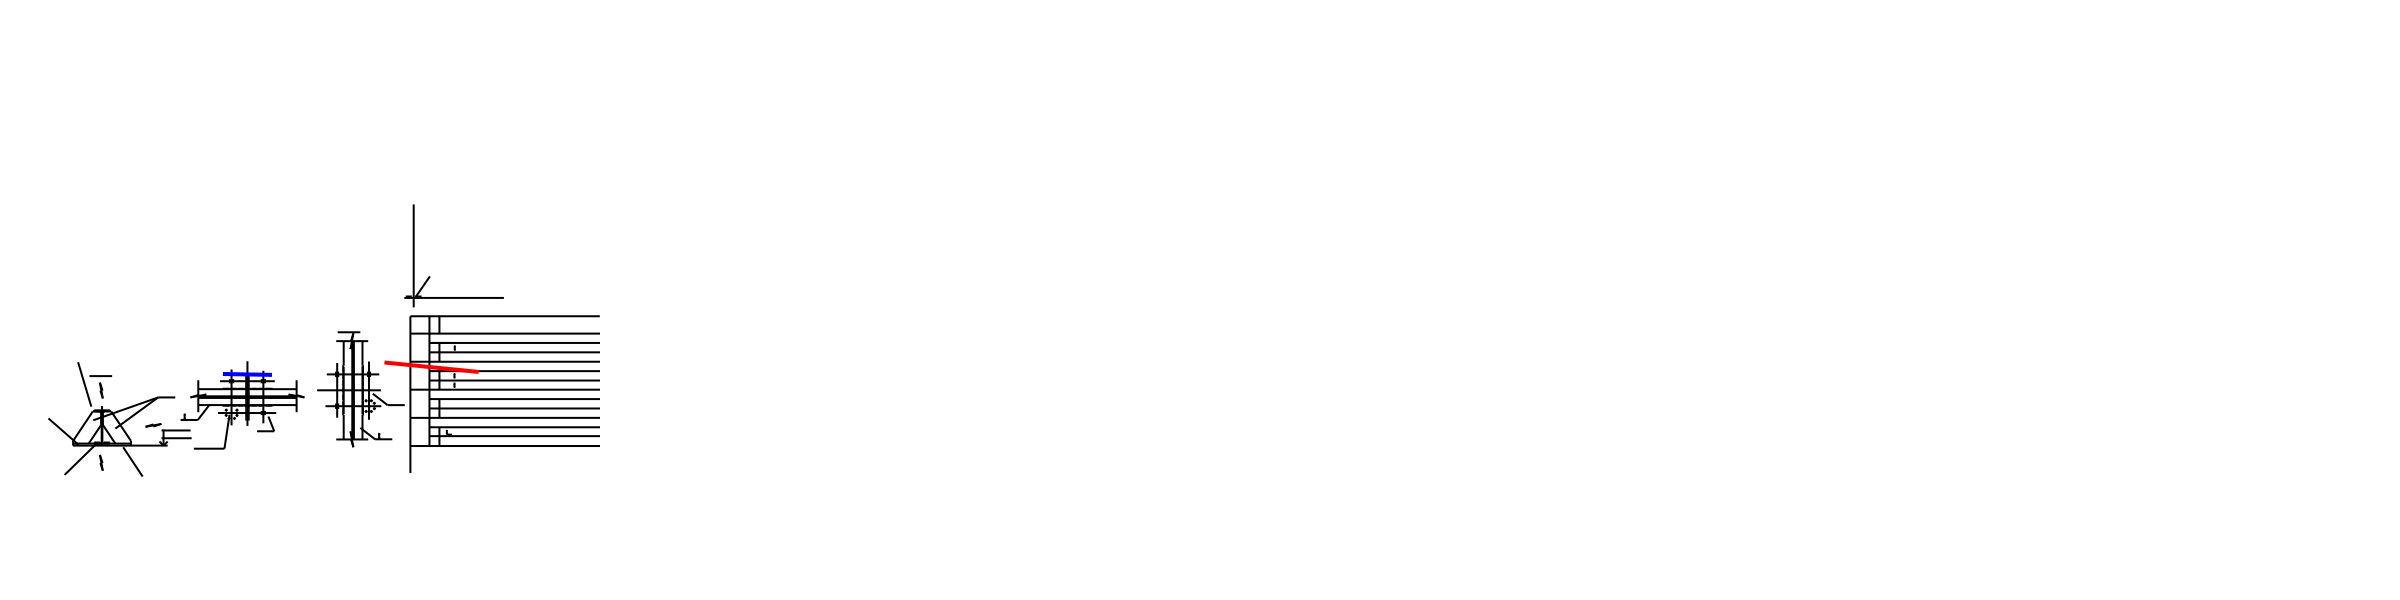

tensor([0.6857, 0.5987, 0.6700, 0.6066], grad_fn=<SelectBackward>)
entities: 4391


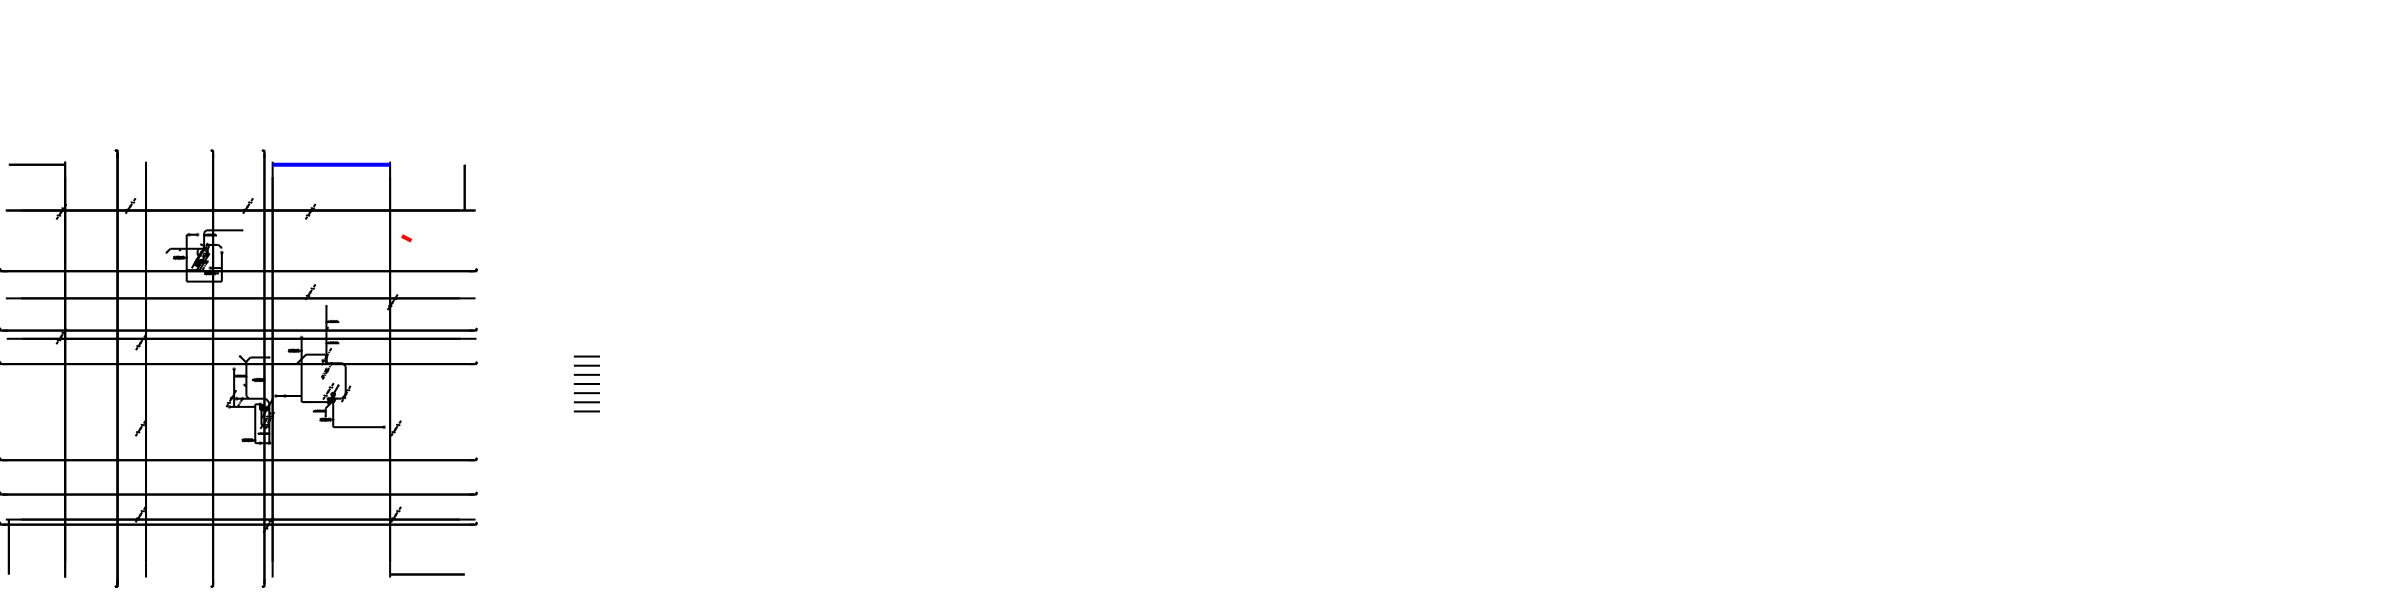

tensor([0.1143, 0.0557, 0.0148, 0.0552], grad_fn=<SelectBackward>)
entities: 17


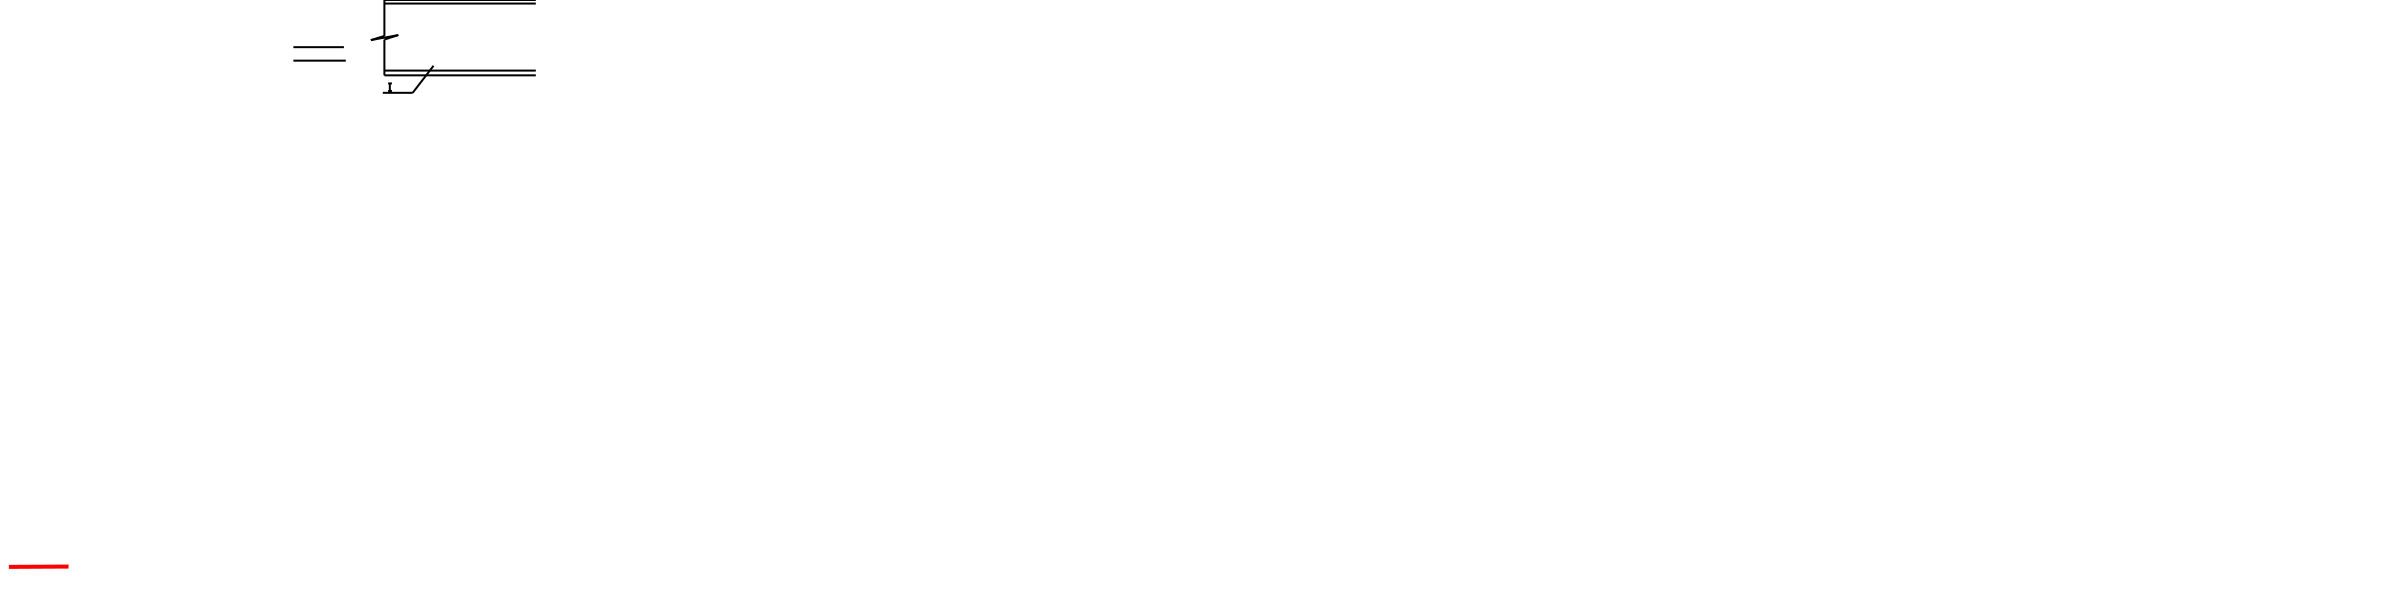

tensor([0.6997, 0.7091, 0.5807, 0.7239], grad_fn=<SelectBackward>)
entities: 89


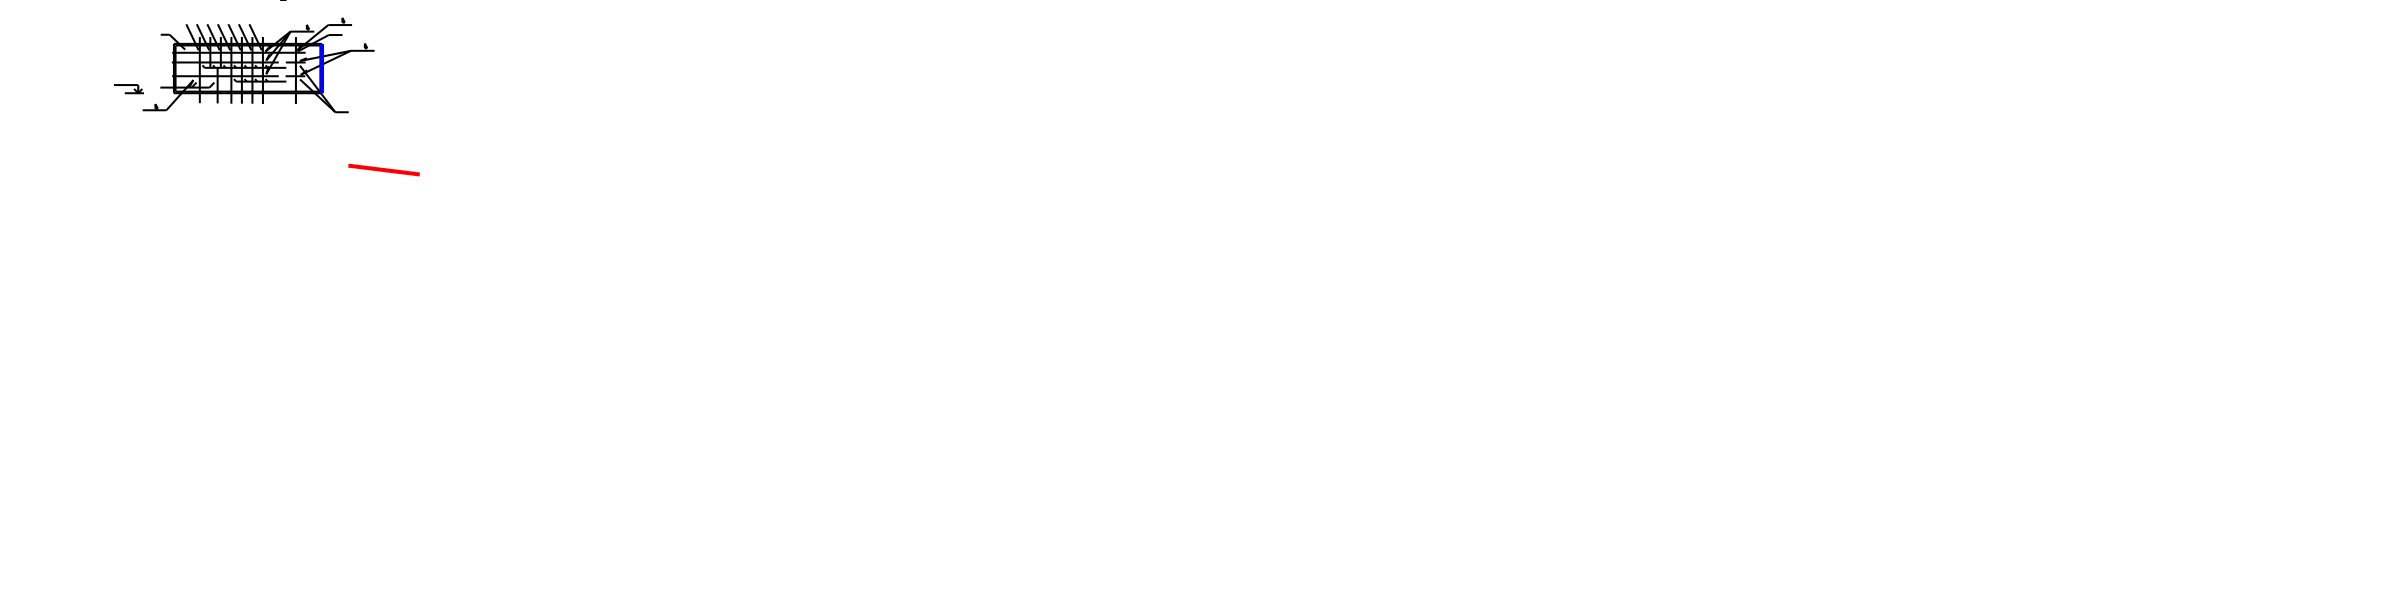

tensor([0.6035, 0.2740, 0.8498, 0.2495], grad_fn=<SelectBackward>)
entities: 468


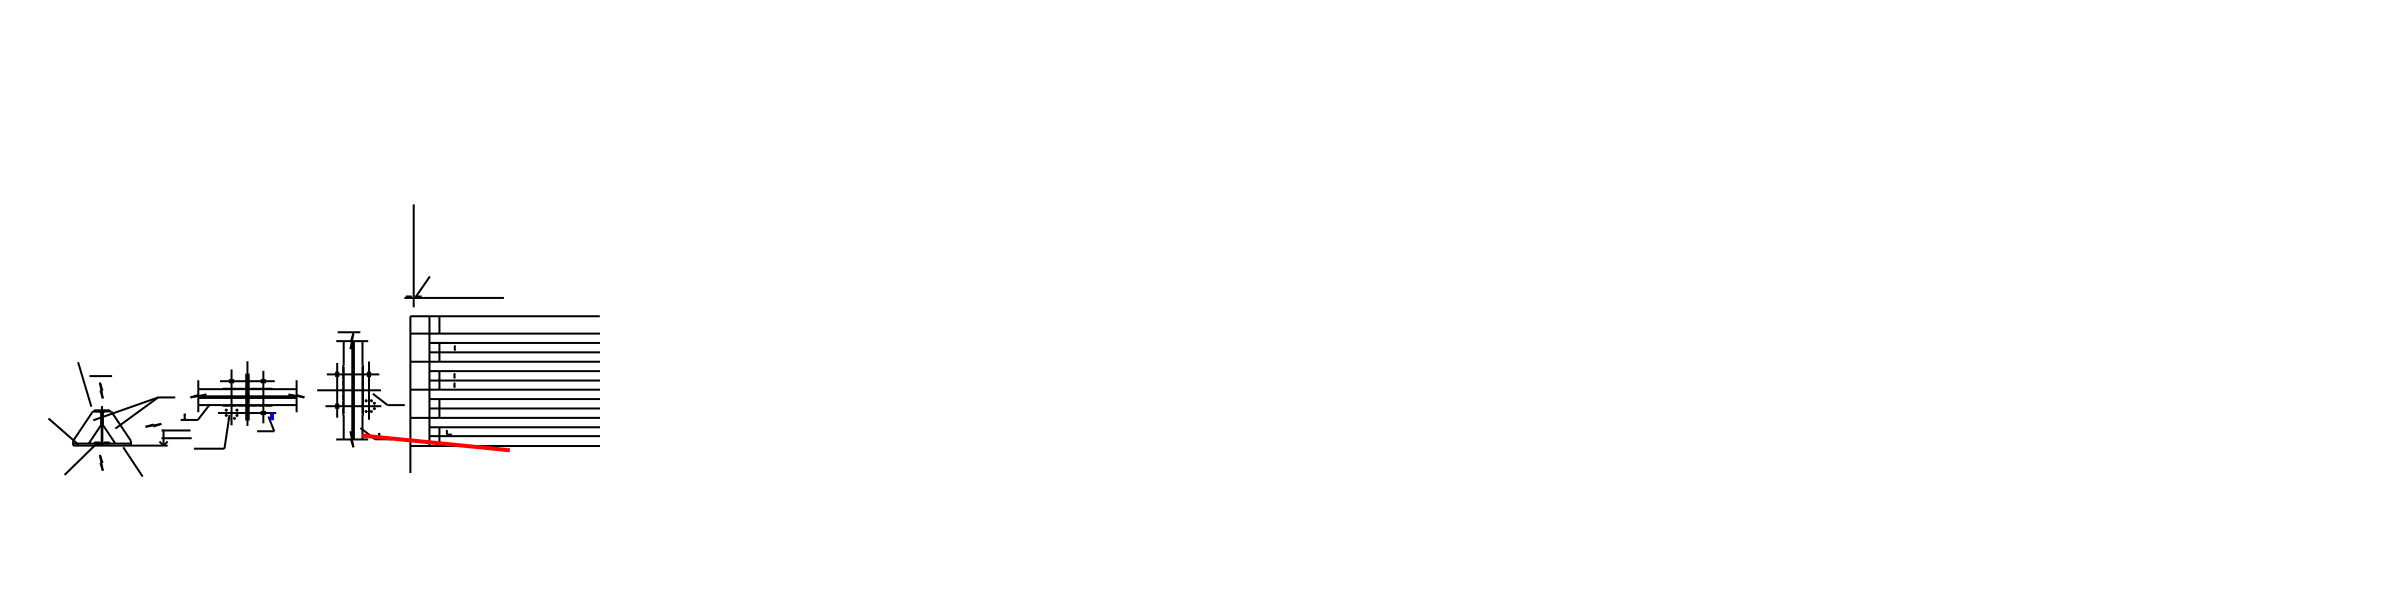

tensor([0.7026, 0.7470, 0.5464, 0.7634], grad_fn=<SelectBackward>)
entities: 151


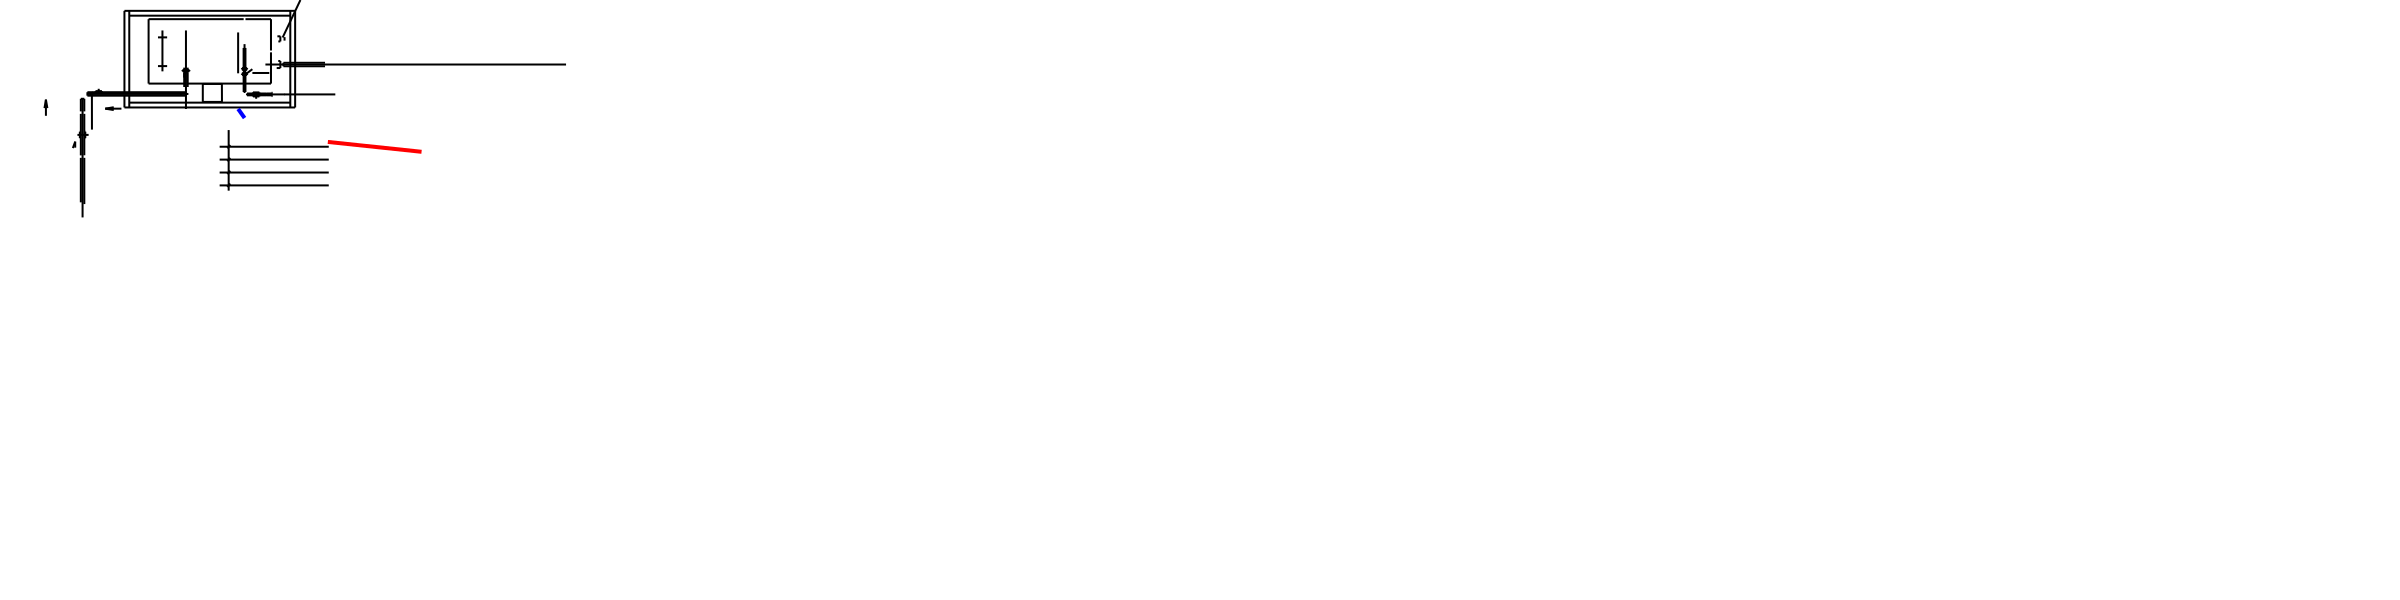

tensor([0.5510, 0.1288, 0.8860, 0.1111], grad_fn=<SelectBackward>)
entities: 3051


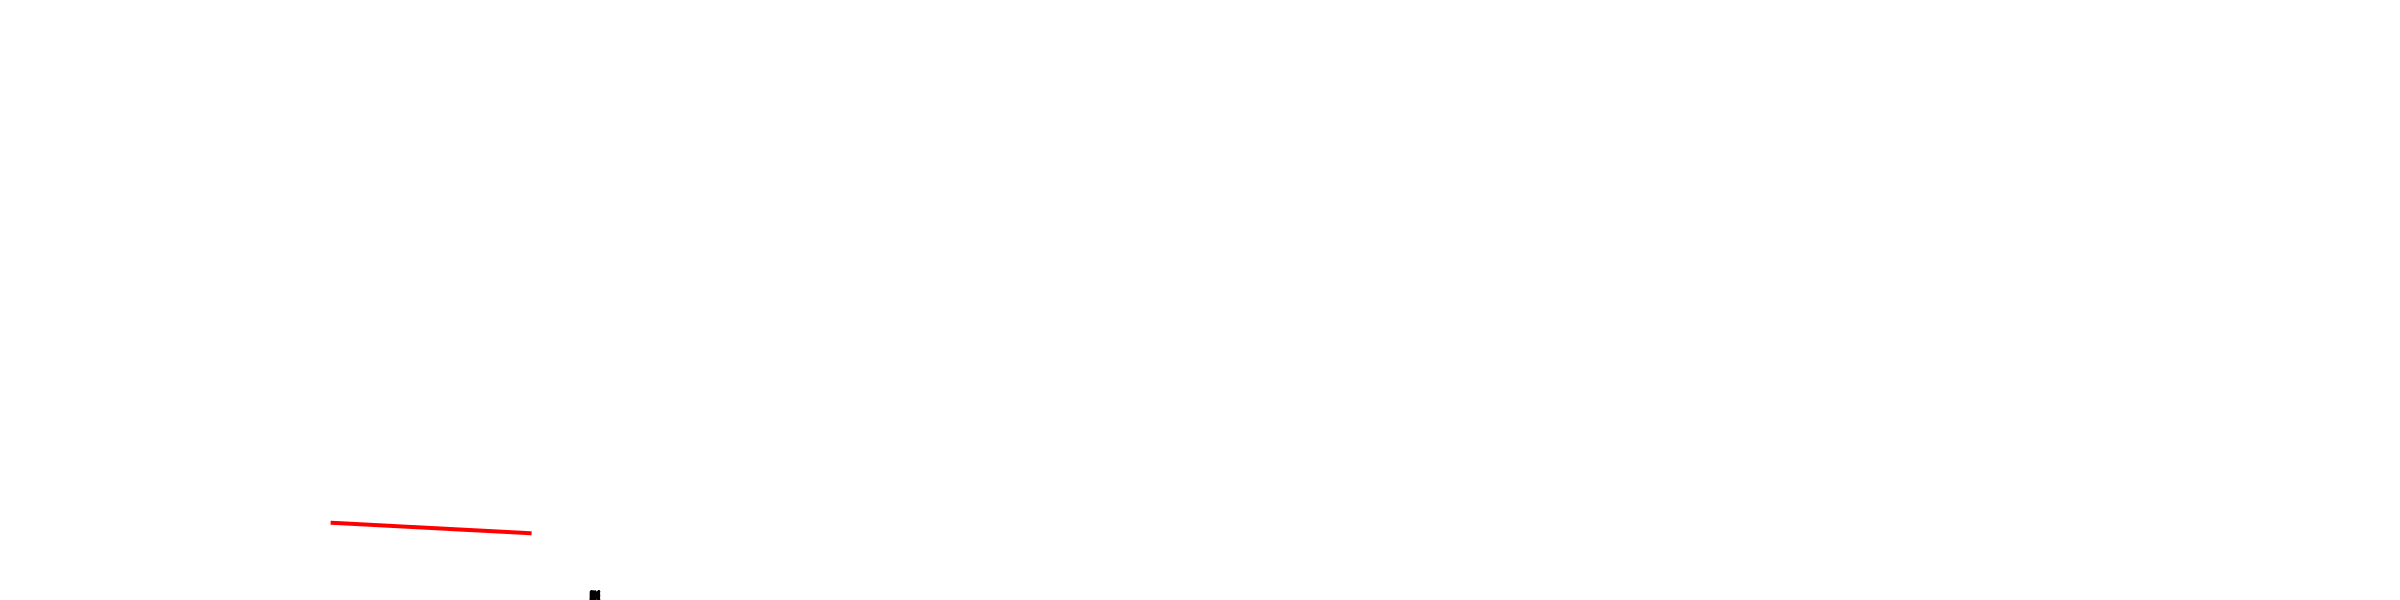

tensor([0.6797, 0.5662, 0.6952, 0.5658], grad_fn=<SelectBackward>)
entities: 1014


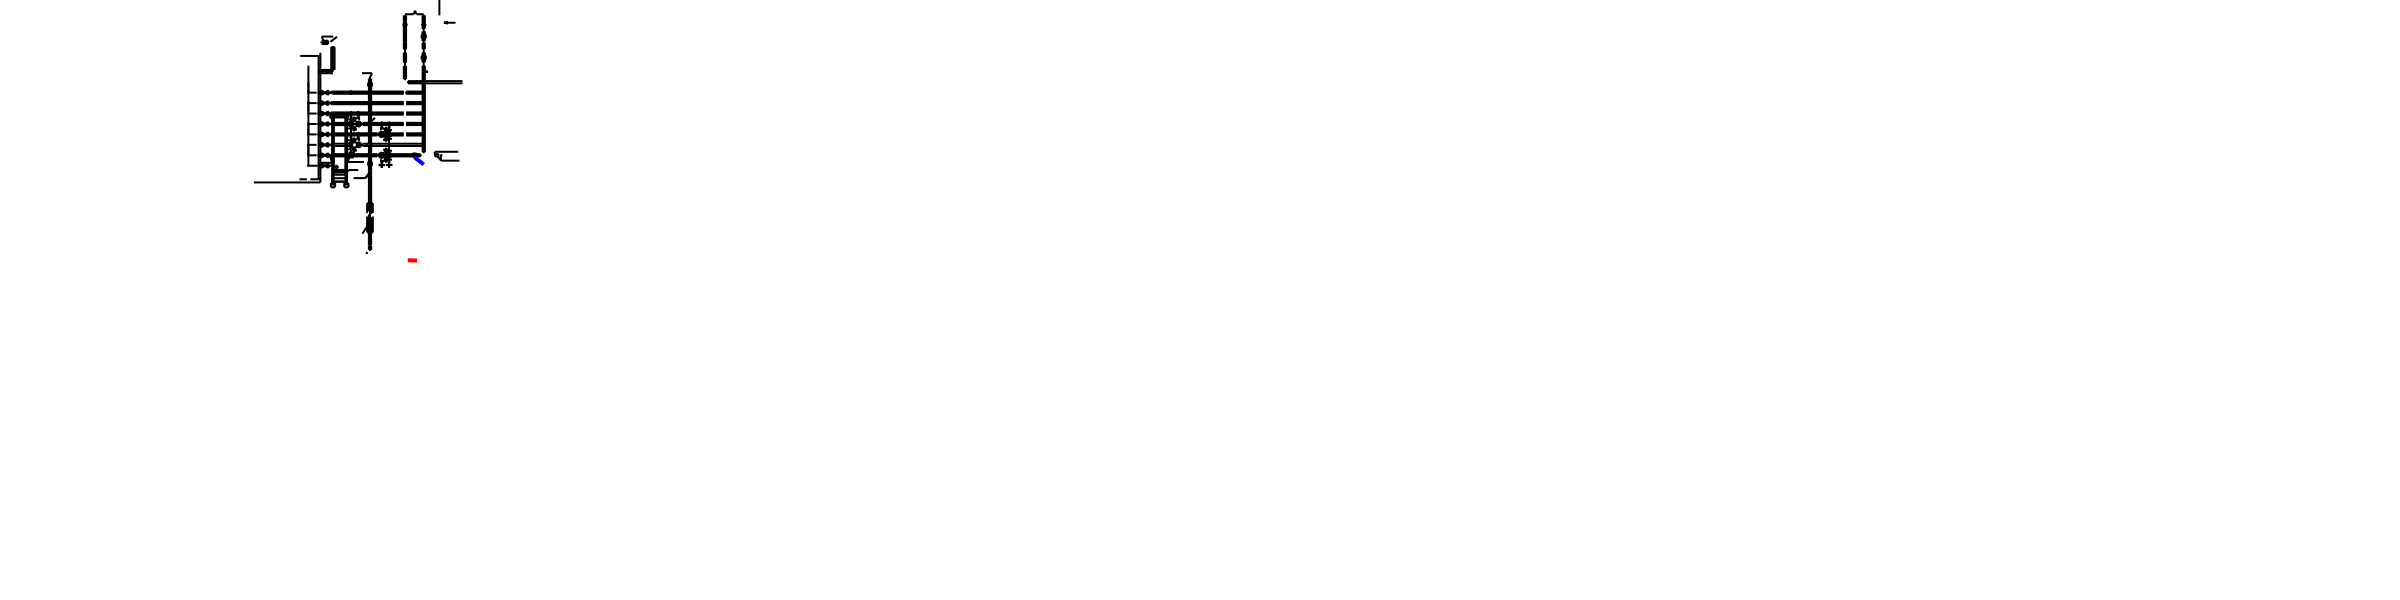

tensor([0.6370, 0.3794, 0.8041, 0.3695], grad_fn=<SelectBackward>)
entities: 468


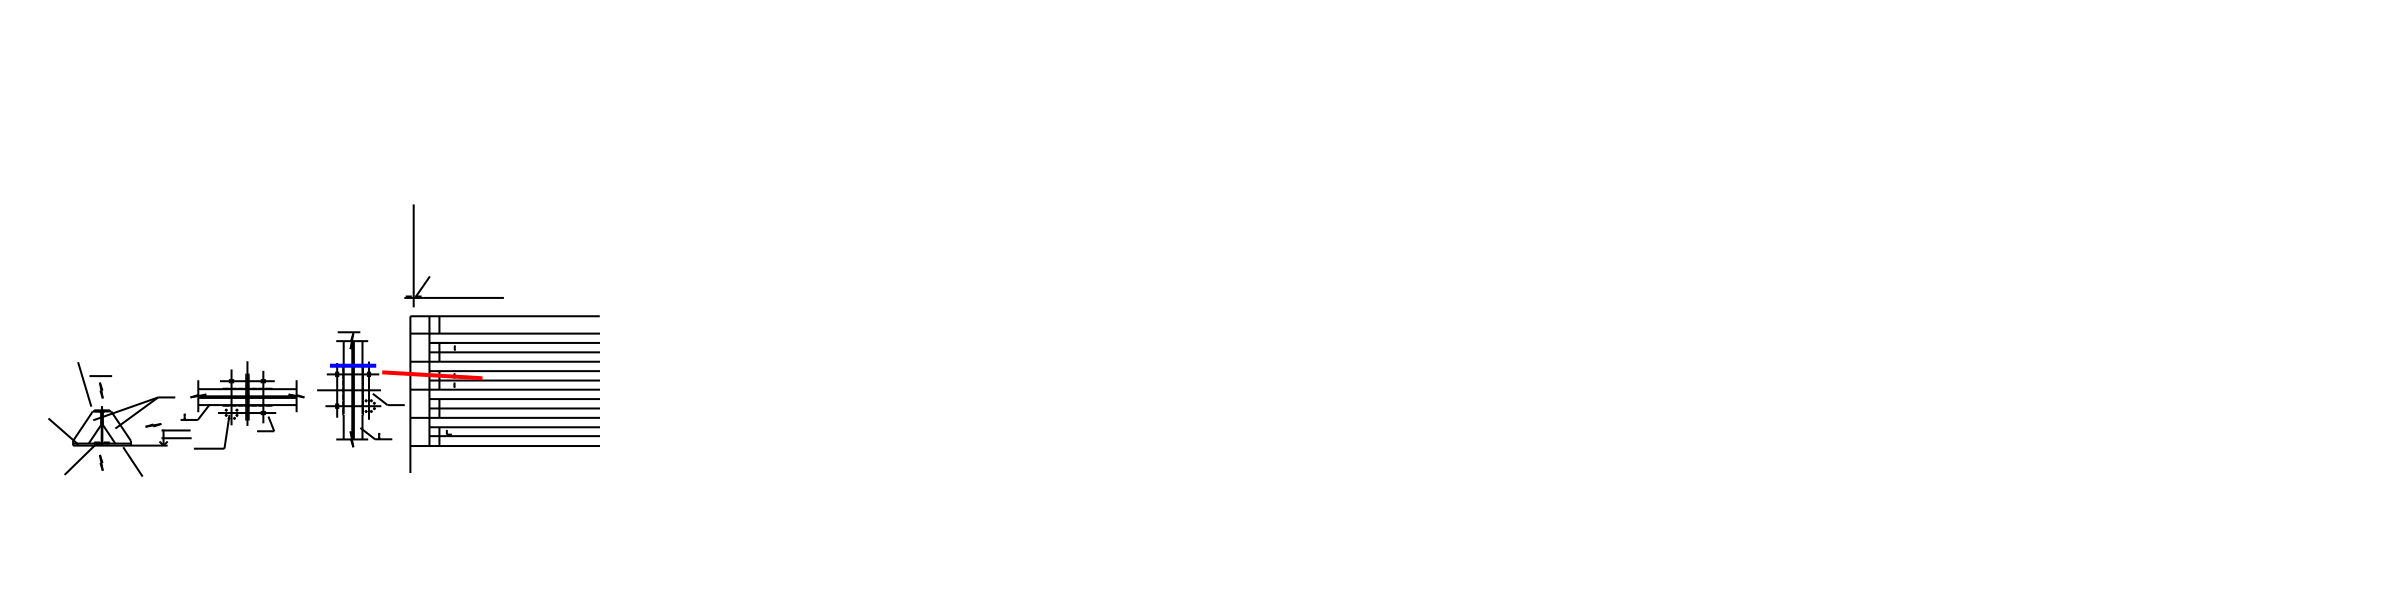

tensor([0.6368, 0.3785, 0.8046, 0.3686], grad_fn=<SelectBackward>)
entities: 1180


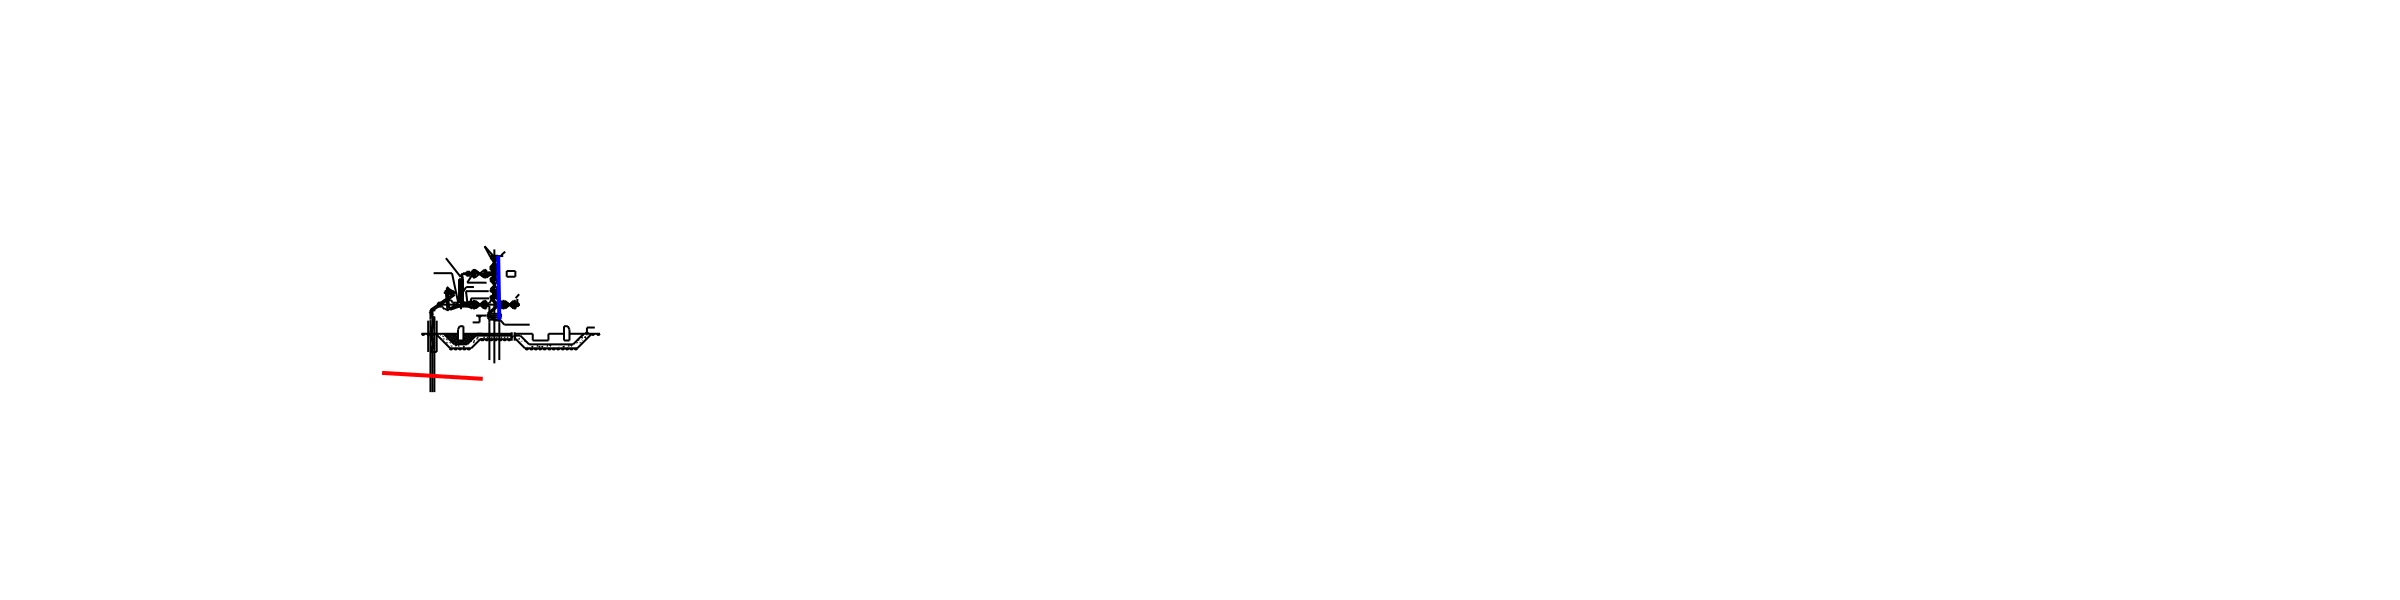

In [6]:
%matplotlib inline
from IPython.display import Image
from IPython.display import clear_output

for j, (_x,_y) in enumerate(dwg_dataset.train_loader):
    _p = model(_x,_y)
    
    for i in range(len(_x)):
        x=_x[i]
        y=_y[i]
        p=_p[i]
        
        print(p)
        graphics = draw_sample(x,y,p, verbose=False)
        display(graphics) 
        #clear_output(wait=True)   
    if j>10:
        break